<a href="https://colab.research.google.com/github/Yossiezraa/TA-Yossi-Ezra-Afriani-2025/blob/main/TA_Analisis_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ANALISIS KOMPARATIF MODEL PRA-TERLATIH DEEP LEARNING UNTUK KLASIFIKASI PENYAKIT KULIT WAJAH

In [ ]:
import random
import numpy as np
import torch

def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False)

set_random_seed()

In [ ]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, random_split

from torchvision.models import (
    resnet34, ResNet34_Weights,
    resnet50, ResNet50_Weights,
    resnet101, ResNet101_Weights,
    convnext_tiny, ConvNeXt_Tiny_Weights,
    convnext_small, ConvNeXt_Small_Weights,
    convnext_base, ConvNeXt_Base_Weights,
    convnext_large, ConvNeXt_Large_Weights,
    mobilenet_v3_small, MobileNet_V3_Small_Weights,
    mobilenet_v3_large, MobileNet_V3_Large_Weights,
    efficientnet_v2_s, EfficientNet_V2_S_Weights,
    efficientnet_v2_m, EfficientNet_V2_M_Weights,
    efficientnet_v2_l, EfficientNet_V2_L_Weights
)

In [ ]:
!pip install git+https://github.com/zhanghang1989/ResNeSt.git

  Cloning https://github.com/zhanghang1989/ResNeSt.git to /tmp/pip-req-build-4rf4j6h8
  Running command git clone --filter=blob:none --quiet https://github.com/zhanghang1989/ResNeSt.git /tmp/pip-req-build-4rf4j6h8
  Resolved https://github.com/zhanghang1989/ResNeSt.git to commit 1dfb3e8867e2ece1c28a65c9db1cded2818a2031
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:

In [ ]:
from resnest.torch import (
    resnest50,
    resnest101,
    resnest200,
    resnest269
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.rmtree('/content/drive', ignore_errors=True)

#Split Data dan Augmentasi


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def count_images_per_class(directory):
    class_counts = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                class_name = root.split(os.path.sep)[-1]
                class_counts[class_name] = class_counts.get(class_name, 0) + 1
    return class_counts

def split_train_val_global(input_train_dir, output_dir, val_count=127):
    all_image_paths = []
    class_labels = []

    for class_name in os.listdir(input_train_dir):
        class_path = os.path.join(input_train_dir, class_name)
        if os.path.isdir(class_path):
            for file in os.listdir(class_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    full_path = os.path.join(class_path, file)
                    all_image_paths.append(full_path)
                    class_labels.append(class_name)

    train_files, val_files = train_test_split(
        all_image_paths,
        test_size=val_count,
        random_state=42
    )

    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for file_path in train_files:
        class_name = os.path.basename(os.path.dirname(file_path))
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        shutil.copy(file_path, os.path.join(train_dir, class_name, os.path.basename(file_path)))

    for file_path in val_files:
        class_name = os.path.basename(os.path.dirname(file_path))
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        shutil.copy(file_path, os.path.join(val_dir, class_name, os.path.basename(file_path)))

    print(f"Jumlah gambar (Train): {len(train_files)}")
    print(f"Jumlah gambar (Validation): {len(val_files)}")

input_train_dir = '/content/drive/MyDrive/Clean Dataset Skin-90/Training'
output_dir = '/content/drive/MyDrive/Clean Dataset Skin-90/Split Data'

counts = count_images_per_class(input_train_dir)
print("Distribusi gambar sebelum split:", counts)

split_train_val_global(input_train_dir, output_dir, val_count=127)

print("Split selesai")

Distribusi gambar sebelum split: {'rosacea': 56, 'whitehead': 63, 'milia': 62, 'psoriasis': 25, 'panu': 20, 'Tinea facialis': 38, 'melanoma': 6, 'papula': 35, 'Pustula': 29, 'kutil filiform': 21, 'Karsinoma': 20, 'blackhead': 23, 'Dermatitis perioral': 50, 'flek hitam': 62, 'folikulitis': 30, 'Eksim': 52, 'herpes': 24, 'acne fulminans': 38, 'acne nodules': 38, 'fungal acne': 56}
Jumlah gambar (Train): 621
Jumlah gambar (Validation): 127
Split selesai dengan validasi presisi 127 gambar.


In [ ]:
import random
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from collections import defaultdict

input_dir = "/content/drive/MyDrive/Clean Dataset Skin-90/Split Data/train"
output_dir = "/content/drive/MyDrive/Clean Dataset Skin-90/Split Data/train_augmented"

augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3)
])

TARGET_COUNT = 150

os.makedirs(output_dir, exist_ok=True)
for class_name in os.listdir(input_dir):
    os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

for class_name in tqdm(os.listdir(input_dir), desc="Processing classes"):
    class_path = os.path.join(input_dir, class_name)
    image_paths = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

    current_count = len(image_paths)
    copy_to_output = os.path.join(output_dir, class_name)

    for img_path in image_paths:
        img = Image.open(img_path).convert("RGB")
        img.save(os.path.join(copy_to_output, os.path.basename(img_path)))

    if current_count < TARGET_COUNT:
        needed = TARGET_COUNT - current_count
        for i in range(needed):
            img_path = random.choice(image_paths)
            img = Image.open(img_path).convert("RGB")
            aug_img = augment_transform(img)
            filename = os.path.basename(img_path).split('.')[0]
            aug_img.save(os.path.join(copy_to_output, f"{filename}_aug{i}.jpg"))

Processing classes: 100%|██████████| 20/20 [01:06<00:00,  3.33s/it]


#Dataset

In [ ]:
from torchvision import datasets

img_size = 224
batch_size = 32

base_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_path = "/content/drive/MyDrive/Clean Dataset Skin-90/Split Data/train"
val_path = "/content/drive/MyDrive/Clean Dataset Skin-90/Split Data/val"
test_path = "/content/drive/MyDrive/Clean Dataset Skin-90/Test"

train_dataset = datasets.ImageFolder(root=train_path, transform=base_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=base_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=base_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print(f"Train total images: {len(train_dataset)}")
print(f"Val total images: {len(val_dataset)}")
print(f"Test total images: {len(test_dataset)}")

Train total images: 621
Val total images: 127
Test total images: 127


In [ ]:
from collections import Counter

def count_images_per_class(folder_path):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            num_images = len(os.listdir(class_folder))
            class_counts[class_name] = num_images
    return class_counts

train_counts = count_images_per_class('/content/drive/MyDrive/Clean Dataset Skin-90/Split Data/train_augmented')
test_counts = count_images_per_class('/content/drive/MyDrive/Clean Dataset Skin-90/Test')
val_counts = count_images_per_class('/content/drive/MyDrive/Clean Dataset Skin-90/Split Data/val')

print("Train class distribution:")
print(train_counts)

print("\nTest class distribution:")
print(test_counts)

print("\nValid class distribution:")
print(val_counts)

Train class distribution:
{'Dermatitis perioral': 150, 'melanoma': 150, 'acne nodules': 150, 'Tinea facialis': 150, 'rosacea': 150, 'panu': 150, 'kutil filiform': 150, 'folikulitis': 150, 'Karsinoma': 150, 'Pustula': 150, 'whitehead': 150, 'flek hitam': 150, 'blackhead': 150, 'milia': 150, 'acne fulminans': 150, 'herpes': 150, 'Eksim': 150, 'psoriasis': 150, 'fungal acne': 150, 'papula': 150}

Test class distribution:
{'panu': 7, 'melanoma': 7, 'rosacea': 7, 'papula': 7, 'Tinea facialis': 7, 'milia': 7, 'Pustula': 7, 'psoriasis': 7, 'whitehead': 7, 'kutil filiform': 7, 'folikulitis': 7, 'Dermatitis perioral': 7, 'blackhead': 7, 'fungal acne': 7, 'Karsinoma': 7, 'acne nodules': 7, 'acne fulminans': 7, 'herpes': 10, 'Eksim': 7, 'flek hitam': 7}

Valid class distribution:
{'Eksim': 8, 'Karsinoma': 6, 'milia': 6, 'Tinea facialis': 8, 'papula': 6, 'blackhead': 3, 'kutil filiform': 3, 'folikulitis': 3, 'fungal acne': 11, 'whitehead': 15, 'Pustula': 5, 'panu': 5, 'melanoma': 1, 'rosacea': 10,

#Model

In [ ]:
def get_model(model_name):
    if model_name == 'resnet34':
        return resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
    elif model_name == 'resnet50':
        return resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    elif model_name == 'resnet101':
        return resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
    elif model_name == 'convnext_tiny':
        return convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
    elif model_name == 'convnext_small':
        return convnext_small(weights=ConvNeXt_Small_Weights.IMAGENET1K_V1)
    elif model_name == 'convnext_base':
        return convnext_base(weights=ConvNeXt_Base_Weights.IMAGENET1K_V1)
    elif model_name == 'convnext_large':
        return convnext_large(weights=ConvNeXt_Large_Weights.IMAGENET1K_V1)
    elif model_name == 'mobilenet_v3_small':
        return mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
    elif model_name == 'mobilenet_v3_large':
        return mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1)
    elif model_name == 'efficientnet_v2_s':
        return efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)
    elif model_name == 'efficientnet_v2_m':
        return efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1)
    elif model_name == 'efficientnet_v2_l':
        return efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1)
    elif model_name == 'resnest50':
        return resnest50(pretrained=True)
    elif model_name == 'resnest101':
        return resnest101(pretrained=True)
    elif model_name == 'resnest200':
        return resnest200(pretrained=True)
    elif model_name == 'resnest269':
        return resnest269(pretrained=True)
    else:
        raise ValueError("Unsupported model name.")

In [ ]:
def create_model(model_name, num_classes, use_hidden_layer=False):
    model = get_model(model_name)

    for param in model.parameters():
        param.requires_grad = False

    if hasattr(model, 'fc'):
        in_features = model.fc.in_features
        if use_hidden_layer:
            model.fc = nn.Sequential(
                nn.Linear(in_features, 512),
                nn.ReLU(),
                nn.Linear(512, num_classes)
            )
        else:
            model.fc = nn.Linear(in_features, num_classes)

    elif hasattr(model, 'classifier'):
        if isinstance(model.classifier, nn.Sequential):
            layers = list(model.classifier.children())

            for i in reversed(range(len(layers))):
                if isinstance(layers[i], nn.Linear):
                    in_features = layers[i].in_features
                    prefix = layers[:i]
                    break
            else:
                raise ValueError("No Linear layer found in model.classifier.")

            if use_hidden_layer:
                suffix = [
                    nn.Linear(in_features, 512),
                    nn.ReLU(),
                    nn.Linear(512, num_classes)
                ]
            else:
                suffix = [nn.Linear(in_features, num_classes)]

            model.classifier = nn.Sequential(*prefix, *suffix)

        else:
            in_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features, num_classes)

    else:
        raise ValueError("Model does not have a classifier or fc layer.")

    return model

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    final_layer = model.fc if hasattr(model, 'fc') else model.classifier
    optimizer = Adam(final_layer.parameters(), lr=0.001)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_f1_scores, val_f1_scores = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        y_true, y_pred = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)
        train_f1_scores.append(f1_score(y_true, y_pred, average='macro'))

        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()
                val_true.extend(labels.cpu().numpy())
                val_pred.extend(preds.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)
        val_f1_scores.append(f1_score(val_true, val_pred, average='macro'))

        print(f"[{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
              f"Train Acc: {train_accuracies[-1]:.2f}% | Val Acc: {val_accuracies[-1]:.2f}% | "
              f"Train F1: {train_f1_scores[-1]:.4f} | Val F1: {val_f1_scores[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores, num_epochs

In [ ]:
def plot_results(epochs, train_losses, val_losses, train_accuracies, val_accuracies,
                 train_f1_scores, val_f1_scores):
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Val Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_f1_scores, label="Train F1 Score")
    plt.plot(epochs, val_f1_scores, label="Val F1 Score")
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def run_training(model_name, use_hidden_layer, num_epochs=50):
    num_classes = len(train_loader.dataset.classes)

    model = create_model(model_name=model_name, num_classes=num_classes, use_hidden_layer=use_hidden_layer)
    model.to(device)

    train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores, actual_epochs = train_model(model, train_loader, val_loader, num_epochs=num_epochs)

    results_df = pd.DataFrame({
        "Epoch": range(1, actual_epochs + 1),
        "Train Loss": train_losses,
        "Train Accuracy": train_accuracies,
        "Train F1 Score": train_f1_scores,
        "Val Loss": val_losses,
        "Val Accuracy": val_accuracies,
        "Val F1 Score": val_f1_scores,
    })

    os.makedirs("/content/drive/MyDrive/Tugas Akhir Code/Hasil Training", exist_ok=True)
    suffix = f"{model_name}_{'1hidden' if use_hidden_layer else '0hidden'}"
    results_df.to_csv(f"/content/drive/MyDrive/Tugas Akhir Code/Hasil Training/hasil_{suffix}.csv", index=False)

    plot_results(range(1, actual_epochs + 1), train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores)

#ConvNext_Tiny 0 hidden layer

[1/50] Train Loss: 1.9967 | Val Loss: 1.7036 | Train Acc: 48.57% | Val Acc: 51.97% | Train F1: 0.4817 | Val F1: 0.3690
[2/50] Train Loss: 1.1270 | Val Loss: 1.5090 | Train Acc: 73.27% | Val Acc: 56.69% | Train F1: 0.7299 | Val F1: 0.4782
[3/50] Train Loss: 0.8329 | Val Loss: 1.4071 | Train Acc: 80.37% | Val Acc: 63.78% | Train F1: 0.8021 | Val F1: 0.5707
[4/50] Train Loss: 0.6777 | Val Loss: 1.3743 | Train Acc: 83.60% | Val Acc: 67.72% | Train F1: 0.8350 | Val F1: 0.5888
[5/50] Train Loss: 0.5686 | Val Loss: 1.3478 | Train Acc: 87.63% | Val Acc: 66.14% | Train F1: 0.8756 | Val F1: 0.5867
[6/50] Train Loss: 0.4934 | Val Loss: 1.3504 | Train Acc: 89.90% | Val Acc: 64.57% | Train F1: 0.8985 | Val F1: 0.5510
[7/50] Train Loss: 0.4308 | Val Loss: 1.3361 | Train Acc: 91.10% | Val Acc: 69.29% | Train F1: 0.9105 | Val F1: 0.6029
[8/50] Train Loss: 0.3881 | Val Loss: 1.3728 | Train Acc: 92.33% | Val Acc: 65.35% | Train F1: 0.9231 | Val F1: 0.5522
[9/50] Train Loss: 0.3396 | Val Loss: 1.3639 | T

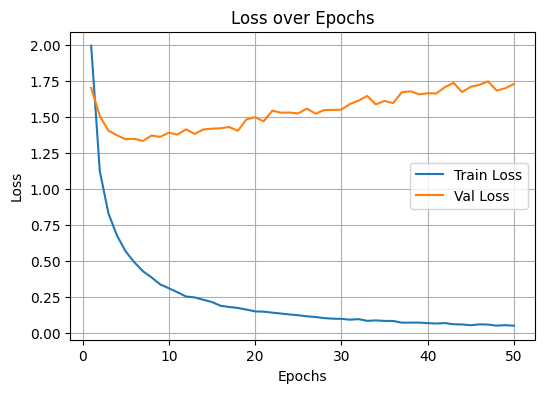

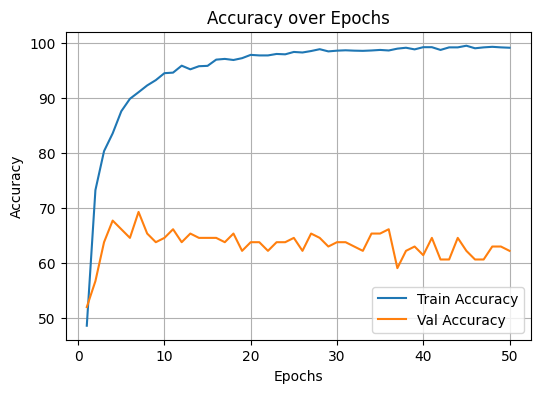

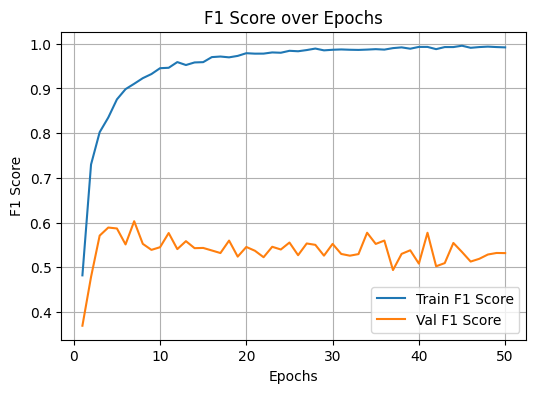

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="convnext_tiny", use_hidden_layer=False, num_epochs=50)

#ConvNext_Tiny 1 hidden layer

[1/50] Train Loss: 1.4963 | Val Loss: 1.4336 | Train Acc: 55.87% | Val Acc: 64.57% | Train F1: 0.5565 | Val F1: 0.5335
[2/50] Train Loss: 0.5589 | Val Loss: 1.3472 | Train Acc: 83.73% | Val Acc: 66.93% | Train F1: 0.8361 | Val F1: 0.5756
[3/50] Train Loss: 0.3216 | Val Loss: 1.5277 | Train Acc: 91.17% | Val Acc: 62.20% | Train F1: 0.9109 | Val F1: 0.5510
[4/50] Train Loss: 0.2327 | Val Loss: 1.5153 | Train Acc: 93.03% | Val Acc: 65.35% | Train F1: 0.9302 | Val F1: 0.5511
[5/50] Train Loss: 0.1509 | Val Loss: 1.5296 | Train Acc: 96.20% | Val Acc: 66.14% | Train F1: 0.9620 | Val F1: 0.5754
[6/50] Train Loss: 0.1118 | Val Loss: 1.4920 | Train Acc: 97.40% | Val Acc: 66.93% | Train F1: 0.9740 | Val F1: 0.5598
[7/50] Train Loss: 0.0928 | Val Loss: 1.6145 | Train Acc: 97.43% | Val Acc: 62.99% | Train F1: 0.9743 | Val F1: 0.5580
[8/50] Train Loss: 0.0740 | Val Loss: 1.9194 | Train Acc: 98.37% | Val Acc: 62.20% | Train F1: 0.9836 | Val F1: 0.5130
[9/50] Train Loss: 0.0559 | Val Loss: 1.8230 | T

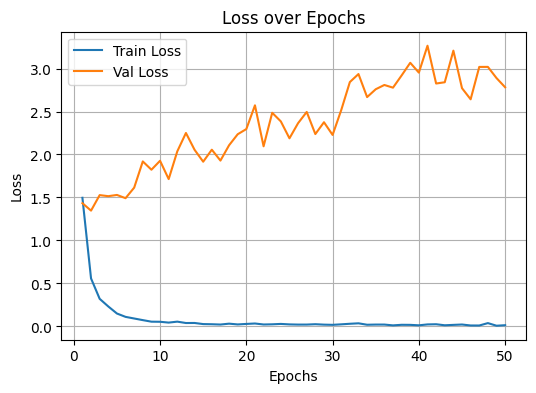

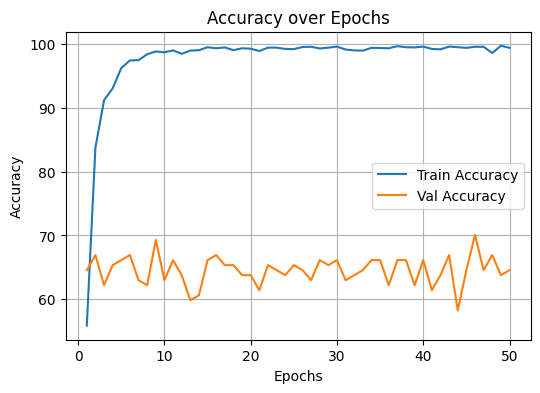

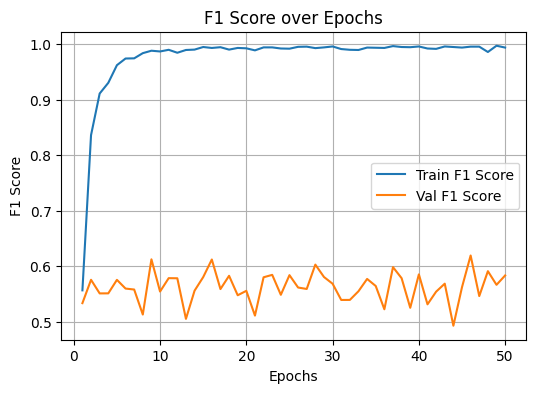

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="convnext_tiny", use_hidden_layer=True, num_epochs=50)

#ConvNext_Small 0 hidden layer

Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:03<00:00, 63.9MB/s]


[1/50] Train Loss: 2.0466 | Val Loss: 1.7277 | Train Acc: 45.50% | Val Acc: 50.39% | Train F1: 0.4500 | Val F1: 0.4169
[2/50] Train Loss: 1.2413 | Val Loss: 1.5271 | Train Acc: 69.50% | Val Acc: 53.54% | Train F1: 0.6929 | Val F1: 0.4353
[3/50] Train Loss: 0.9611 | Val Loss: 1.4390 | Train Acc: 75.77% | Val Acc: 64.57% | Train F1: 0.7551 | Val F1: 0.5507
[4/50] Train Loss: 0.8093 | Val Loss: 1.4053 | Train Acc: 79.27% | Val Acc: 65.35% | Train F1: 0.7914 | Val F1: 0.5498
[5/50] Train Loss: 0.7043 | Val Loss: 1.3669 | Train Acc: 82.63% | Val Acc: 63.78% | Train F1: 0.8253 | Val F1: 0.5325
[6/50] Train Loss: 0.6151 | Val Loss: 1.3727 | Train Acc: 84.33% | Val Acc: 64.57% | Train F1: 0.8424 | Val F1: 0.5704
[7/50] Train Loss: 0.5570 | Val Loss: 1.3962 | Train Acc: 86.80% | Val Acc: 63.78% | Train F1: 0.8670 | Val F1: 0.5575
[8/50] Train Loss: 0.5209 | Val Loss: 1.3533 | Train Acc: 87.43% | Val Acc: 66.93% | Train F1: 0.8739 | Val F1: 0.5965
[9/50] Train Loss: 0.4730 | Val Loss: 1.3619 | T

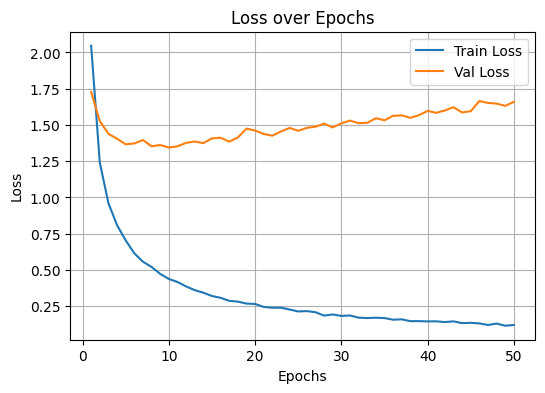

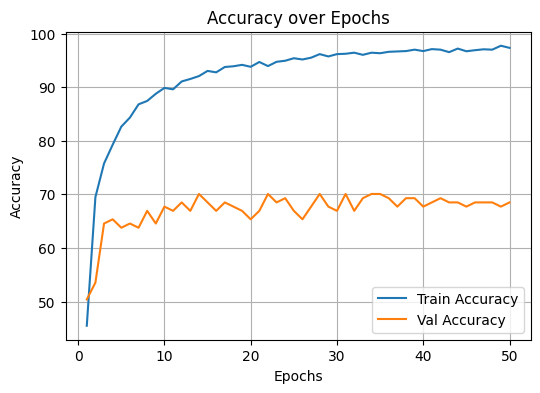

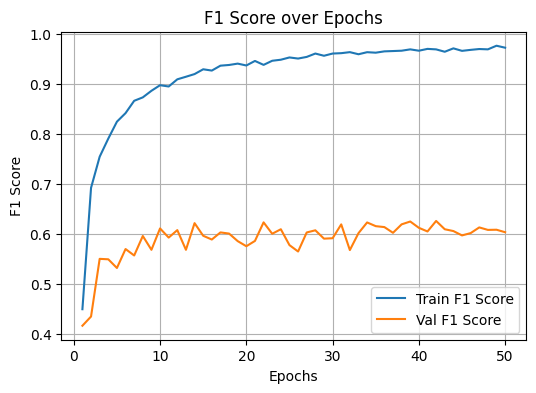

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="convnext_small", use_hidden_layer=False, num_epochs=50)

#ConvNext_Small 1 hidden layer

[1/50] Train Loss: 1.6057 | Val Loss: 1.6518 | Train Acc: 52.90% | Val Acc: 54.33% | Train F1: 0.5236 | Val F1: 0.4587
[2/50] Train Loss: 0.7048 | Val Loss: 1.4929 | Train Acc: 79.27% | Val Acc: 61.42% | Train F1: 0.7918 | Val F1: 0.5400
[3/50] Train Loss: 0.4738 | Val Loss: 1.5543 | Train Acc: 85.87% | Val Acc: 61.42% | Train F1: 0.8576 | Val F1: 0.5425
[4/50] Train Loss: 0.3349 | Val Loss: 1.5836 | Train Acc: 90.43% | Val Acc: 61.42% | Train F1: 0.9038 | Val F1: 0.5240
[5/50] Train Loss: 0.2708 | Val Loss: 1.5376 | Train Acc: 91.73% | Val Acc: 63.78% | Train F1: 0.9171 | Val F1: 0.5294
[6/50] Train Loss: 0.2018 | Val Loss: 1.6864 | Train Acc: 94.23% | Val Acc: 60.63% | Train F1: 0.9423 | Val F1: 0.5326
[7/50] Train Loss: 0.1598 | Val Loss: 1.7320 | Train Acc: 95.53% | Val Acc: 59.84% | Train F1: 0.9551 | Val F1: 0.5080
[8/50] Train Loss: 0.1563 | Val Loss: 1.7190 | Train Acc: 95.53% | Val Acc: 62.99% | Train F1: 0.9553 | Val F1: 0.5519
[9/50] Train Loss: 0.1467 | Val Loss: 1.7735 | T

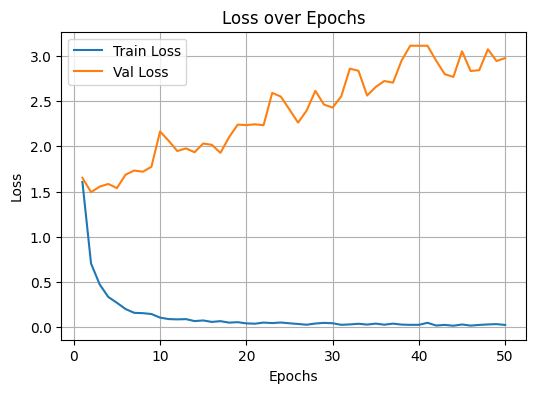

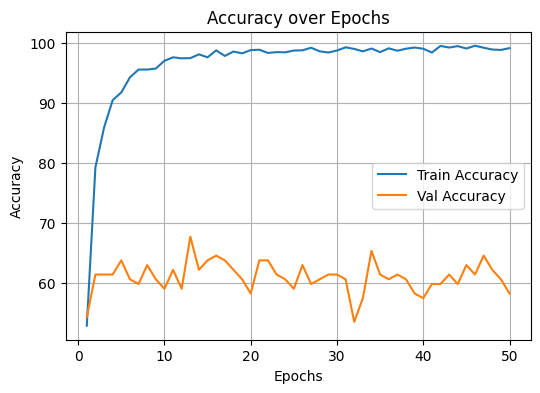

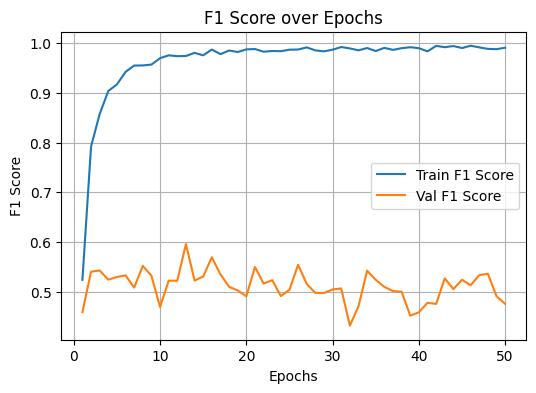

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="convnext_small", use_hidden_layer=True, num_epochs=50)

#ConvNext_Base 0 hidden layer

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:02<00:00, 173MB/s]


[1/50] Train Loss: 2.1031 | Val Loss: 1.8314 | Train Acc: 45.50% | Val Acc: 47.24% | Train F1: 0.4469 | Val F1: 0.3564
[2/50] Train Loss: 1.2918 | Val Loss: 1.5822 | Train Acc: 68.70% | Val Acc: 56.69% | Train F1: 0.6827 | Val F1: 0.4601
[3/50] Train Loss: 0.9887 | Val Loss: 1.4833 | Train Acc: 76.47% | Val Acc: 59.06% | Train F1: 0.7623 | Val F1: 0.4962
[4/50] Train Loss: 0.8273 | Val Loss: 1.4189 | Train Acc: 79.93% | Val Acc: 61.42% | Train F1: 0.7972 | Val F1: 0.5134
[5/50] Train Loss: 0.7024 | Val Loss: 1.4165 | Train Acc: 84.20% | Val Acc: 62.20% | Train F1: 0.8407 | Val F1: 0.5302
[6/50] Train Loss: 0.6363 | Val Loss: 1.3668 | Train Acc: 85.67% | Val Acc: 62.99% | Train F1: 0.8561 | Val F1: 0.5272
[7/50] Train Loss: 0.5615 | Val Loss: 1.3600 | Train Acc: 87.53% | Val Acc: 63.78% | Train F1: 0.8752 | Val F1: 0.5505
[8/50] Train Loss: 0.5175 | Val Loss: 1.3392 | Train Acc: 87.60% | Val Acc: 65.35% | Train F1: 0.8753 | Val F1: 0.5745
[9/50] Train Loss: 0.4732 | Val Loss: 1.3741 | T

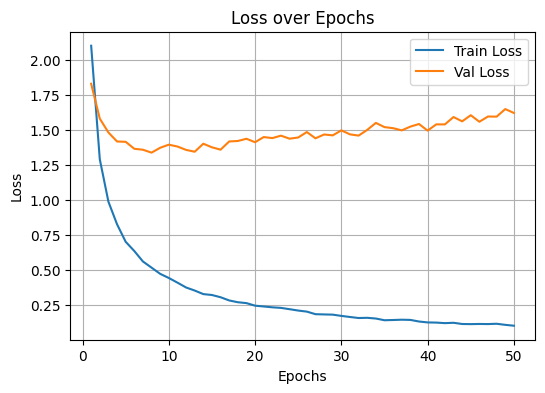

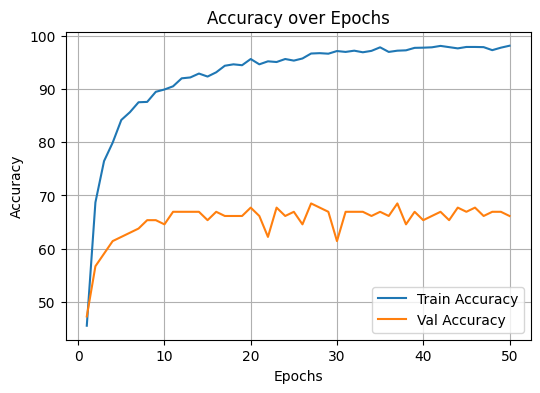

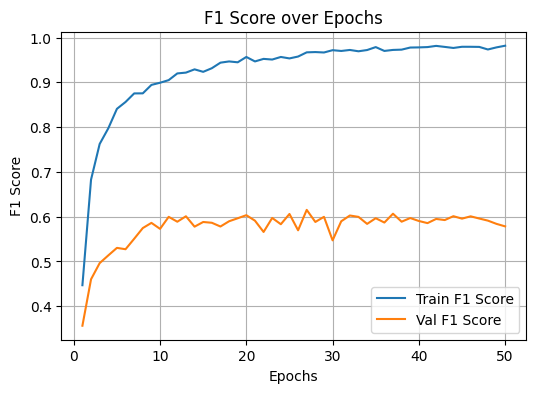

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="convnext_base", use_hidden_layer=False, num_epochs=50)

#ConvNext_Base 1 hidden layer

[1/50] Train Loss: 1.6550 | Val Loss: 1.5193 | Train Acc: 52.27% | Val Acc: 57.48% | Train F1: 0.5170 | Val F1: 0.4600
[2/50] Train Loss: 0.7152 | Val Loss: 1.4283 | Train Acc: 78.90% | Val Acc: 60.63% | Train F1: 0.7871 | Val F1: 0.5364
[3/50] Train Loss: 0.4648 | Val Loss: 1.5767 | Train Acc: 86.77% | Val Acc: 62.20% | Train F1: 0.8672 | Val F1: 0.5634
[4/50] Train Loss: 0.3174 | Val Loss: 1.4486 | Train Acc: 90.83% | Val Acc: 64.57% | Train F1: 0.9078 | Val F1: 0.5678
[5/50] Train Loss: 0.2531 | Val Loss: 1.5635 | Train Acc: 92.27% | Val Acc: 60.63% | Train F1: 0.9224 | Val F1: 0.5403
[6/50] Train Loss: 0.1995 | Val Loss: 1.5160 | Train Acc: 94.63% | Val Acc: 62.20% | Train F1: 0.9462 | Val F1: 0.5542
[7/50] Train Loss: 0.1535 | Val Loss: 1.5478 | Train Acc: 95.97% | Val Acc: 62.99% | Train F1: 0.9597 | Val F1: 0.5740
[8/50] Train Loss: 0.1344 | Val Loss: 1.6017 | Train Acc: 96.23% | Val Acc: 68.50% | Train F1: 0.9623 | Val F1: 0.6136
[9/50] Train Loss: 0.1085 | Val Loss: 1.8705 | T

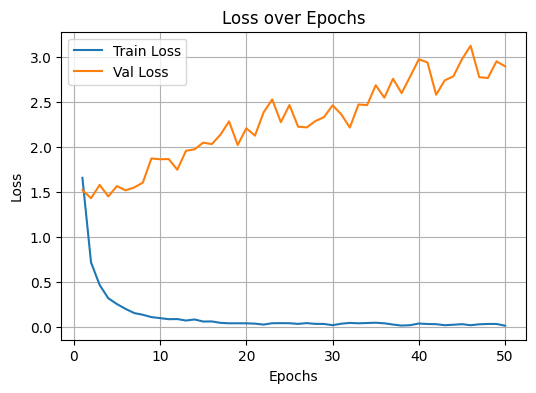

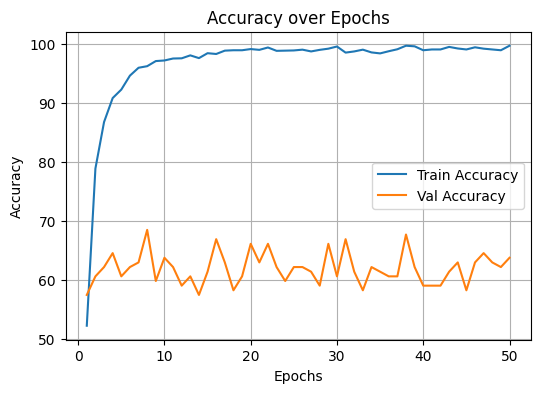

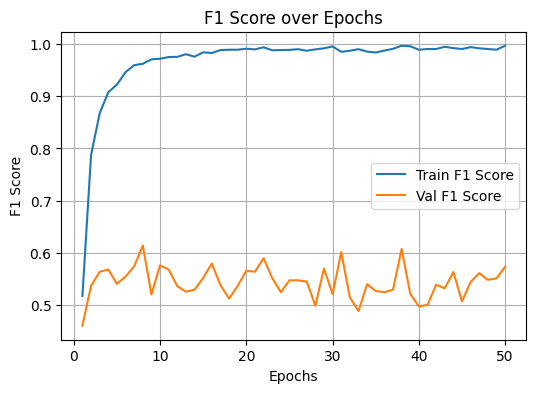

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="convnext_base", use_hidden_layer=True, num_epochs=50)

#ConvNext_Large 0 hidden layer

Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth
100%|██████████| 755M/755M [00:08<00:00, 97.8MB/s]


[1/50] Train Loss: 2.0995 | Val Loss: 1.7947 | Train Acc: 47.37% | Val Acc: 57.48% | Train F1: 0.4699 | Val F1: 0.4537
[2/50] Train Loss: 1.2825 | Val Loss: 1.5734 | Train Acc: 70.20% | Val Acc: 57.48% | Train F1: 0.6985 | Val F1: 0.4596
[3/50] Train Loss: 0.9927 | Val Loss: 1.4946 | Train Acc: 76.60% | Val Acc: 61.42% | Train F1: 0.7629 | Val F1: 0.5262
[4/50] Train Loss: 0.8268 | Val Loss: 1.4597 | Train Acc: 80.07% | Val Acc: 60.63% | Train F1: 0.7994 | Val F1: 0.5225
[5/50] Train Loss: 0.7080 | Val Loss: 1.4347 | Train Acc: 83.37% | Val Acc: 62.99% | Train F1: 0.8327 | Val F1: 0.5558
[6/50] Train Loss: 0.6326 | Val Loss: 1.3930 | Train Acc: 86.40% | Val Acc: 62.20% | Train F1: 0.8635 | Val F1: 0.5464
[7/50] Train Loss: 0.5630 | Val Loss: 1.3958 | Train Acc: 87.57% | Val Acc: 62.99% | Train F1: 0.8744 | Val F1: 0.5573
[8/50] Train Loss: 0.5131 | Val Loss: 1.3772 | Train Acc: 88.77% | Val Acc: 63.78% | Train F1: 0.8869 | Val F1: 0.5684
[9/50] Train Loss: 0.4696 | Val Loss: 1.3910 | T

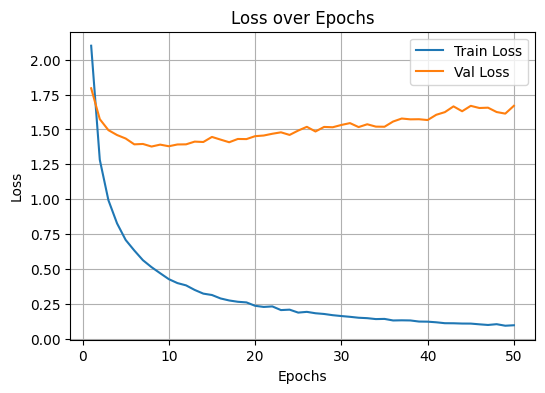

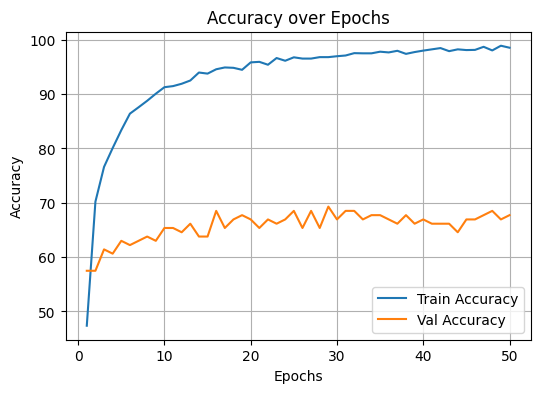

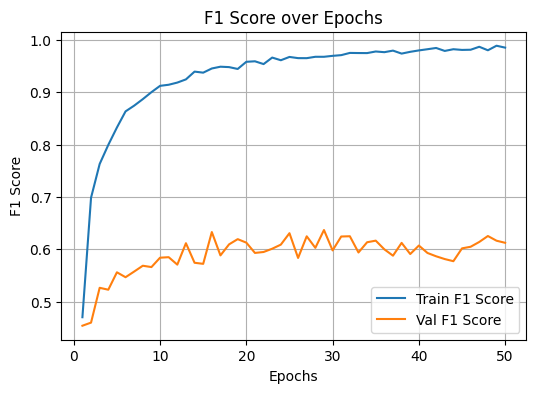

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="convnext_large", use_hidden_layer=False, num_epochs=50)

#ConvNext_Large 1 hidden layer

[1/50] Train Loss: 1.6258 | Val Loss: 1.5891 | Train Acc: 53.13% | Val Acc: 55.12% | Train F1: 0.5240 | Val F1: 0.4529
[2/50] Train Loss: 0.6968 | Val Loss: 1.4399 | Train Acc: 79.17% | Val Acc: 63.78% | Train F1: 0.7896 | Val F1: 0.5703
[3/50] Train Loss: 0.4316 | Val Loss: 1.5771 | Train Acc: 87.67% | Val Acc: 57.48% | Train F1: 0.8759 | Val F1: 0.5289
[4/50] Train Loss: 0.3165 | Val Loss: 1.5604 | Train Acc: 90.93% | Val Acc: 64.57% | Train F1: 0.9088 | Val F1: 0.5640
[5/50] Train Loss: 0.2273 | Val Loss: 1.4403 | Train Acc: 93.23% | Val Acc: 68.50% | Train F1: 0.9322 | Val F1: 0.6316
[6/50] Train Loss: 0.1727 | Val Loss: 1.5997 | Train Acc: 94.93% | Val Acc: 64.57% | Train F1: 0.9494 | Val F1: 0.5617
[7/50] Train Loss: 0.1507 | Val Loss: 1.6331 | Train Acc: 95.43% | Val Acc: 66.14% | Train F1: 0.9543 | Val F1: 0.6076
[8/50] Train Loss: 0.1122 | Val Loss: 1.7079 | Train Acc: 97.27% | Val Acc: 67.72% | Train F1: 0.9726 | Val F1: 0.6172
[9/50] Train Loss: 0.1011 | Val Loss: 1.8289 | T

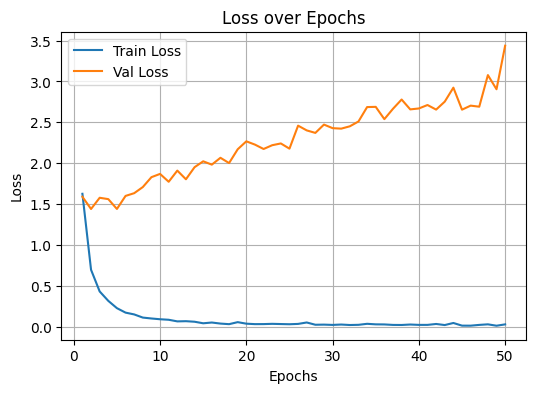

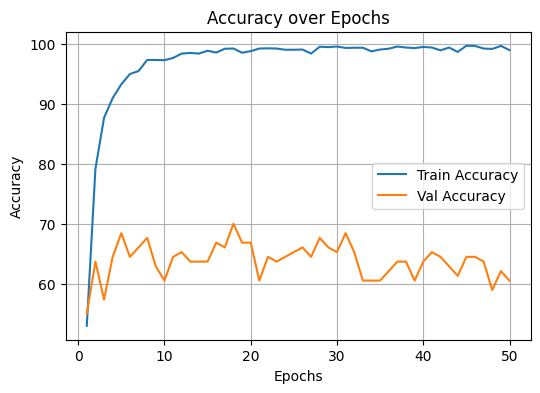

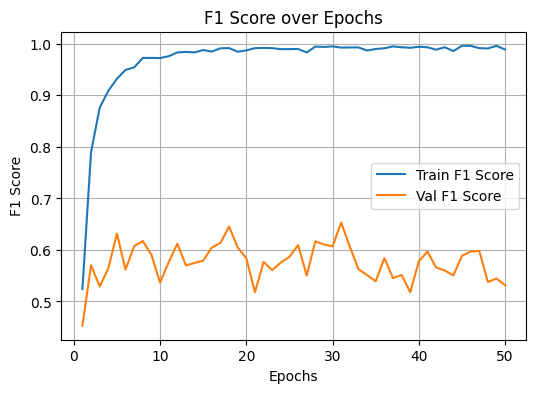

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="convnext_large", use_hidden_layer=True, num_epochs=50)

#EfficientNetV2_S 0 hidden layer

[1/50] Train Loss: 2.5400 | Val Loss: 2.2387 | Train Acc: 32.53% | Val Acc: 44.09% | Train F1: 0.3210 | Val F1: 0.3264
[2/50] Train Loss: 1.8367 | Val Loss: 1.9898 | Train Acc: 56.70% | Val Acc: 47.24% | Train F1: 0.5571 | Val F1: 0.3492
[3/50] Train Loss: 1.5264 | Val Loss: 1.8377 | Train Acc: 62.40% | Val Acc: 51.97% | Train F1: 0.6181 | Val F1: 0.3900
[4/50] Train Loss: 1.3448 | Val Loss: 1.7904 | Train Acc: 65.73% | Val Acc: 49.61% | Train F1: 0.6529 | Val F1: 0.3588
[5/50] Train Loss: 1.2033 | Val Loss: 1.7485 | Train Acc: 69.80% | Val Acc: 53.54% | Train F1: 0.6946 | Val F1: 0.3996
[6/50] Train Loss: 1.1323 | Val Loss: 1.7229 | Train Acc: 69.70% | Val Acc: 53.54% | Train F1: 0.6941 | Val F1: 0.3993
[7/50] Train Loss: 1.0539 | Val Loss: 1.6791 | Train Acc: 72.10% | Val Acc: 51.97% | Train F1: 0.7181 | Val F1: 0.3840
[8/50] Train Loss: 0.9723 | Val Loss: 1.6997 | Train Acc: 74.27% | Val Acc: 53.54% | Train F1: 0.7400 | Val F1: 0.4187
[9/50] Train Loss: 0.9406 | Val Loss: 1.6853 | T

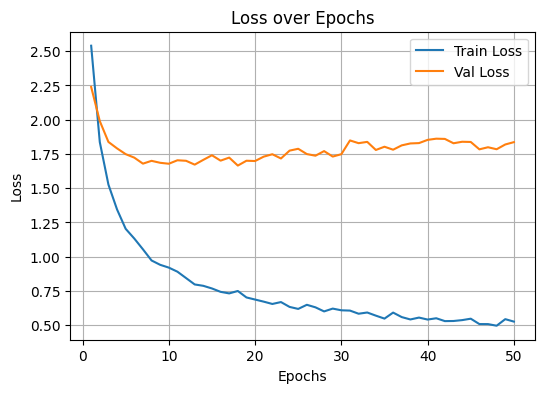

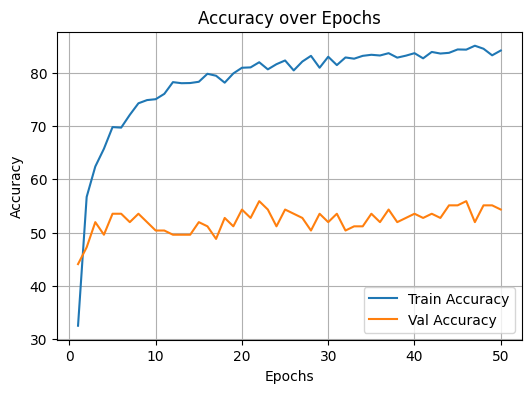

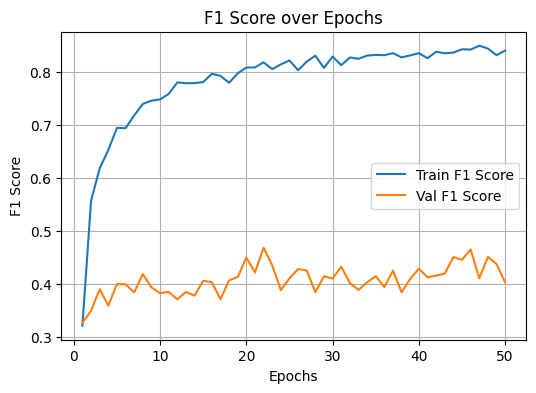

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="efficientnet_v2_s", use_hidden_layer=False, num_epochs=50)

#EfficientNetV2_S 1 hidden layer

[1/50] Train Loss: 2.2009 | Val Loss: 1.8339 | Train Acc: 37.30% | Val Acc: 49.61% | Train F1: 0.3692 | Val F1: 0.3316
[2/50] Train Loss: 1.2950 | Val Loss: 1.7773 | Train Acc: 62.03% | Val Acc: 46.46% | Train F1: 0.6156 | Val F1: 0.3266
[3/50] Train Loss: 1.0349 | Val Loss: 1.7077 | Train Acc: 68.90% | Val Acc: 49.61% | Train F1: 0.6865 | Val F1: 0.3712
[4/50] Train Loss: 0.8853 | Val Loss: 1.8172 | Train Acc: 73.13% | Val Acc: 51.97% | Train F1: 0.7303 | Val F1: 0.3868
[5/50] Train Loss: 0.7740 | Val Loss: 1.7358 | Train Acc: 76.17% | Val Acc: 51.18% | Train F1: 0.7606 | Val F1: 0.3981
[6/50] Train Loss: 0.7084 | Val Loss: 1.7088 | Train Acc: 78.33% | Val Acc: 49.61% | Train F1: 0.7828 | Val F1: 0.4011
[7/50] Train Loss: 0.6533 | Val Loss: 1.7289 | Train Acc: 79.47% | Val Acc: 56.69% | Train F1: 0.7941 | Val F1: 0.4355
[8/50] Train Loss: 0.5678 | Val Loss: 1.7396 | Train Acc: 82.27% | Val Acc: 55.91% | Train F1: 0.8223 | Val F1: 0.4449
[9/50] Train Loss: 0.5146 | Val Loss: 1.8325 | T

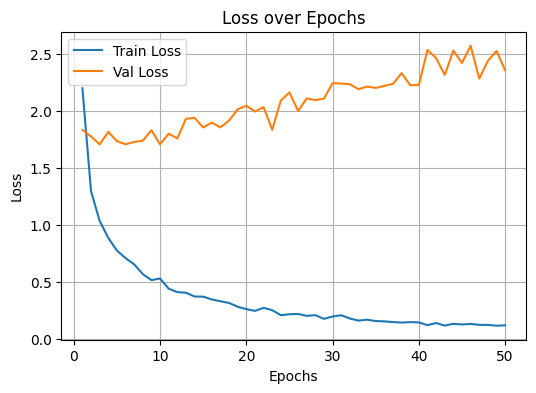

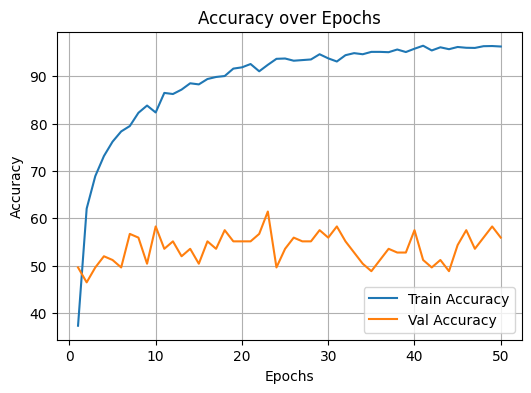

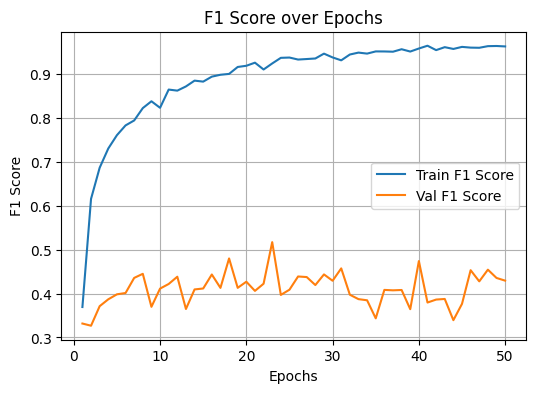

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="efficientnet_v2_s", use_hidden_layer=True, num_epochs=50)

#EfficientNetV2_M 0 hidden layer

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:02<00:00, 87.0MB/s]


[1/50] Train Loss: 2.6447 | Val Loss: 2.3593 | Train Acc: 26.83% | Val Acc: 39.37% | Train F1: 0.2662 | Val F1: 0.2642
[2/50] Train Loss: 2.0374 | Val Loss: 2.0864 | Train Acc: 50.33% | Val Acc: 44.09% | Train F1: 0.4911 | Val F1: 0.2893
[3/50] Train Loss: 1.7306 | Val Loss: 1.9748 | Train Acc: 55.47% | Val Acc: 42.52% | Train F1: 0.5465 | Val F1: 0.3094
[4/50] Train Loss: 1.5691 | Val Loss: 1.9273 | Train Acc: 59.23% | Val Acc: 45.67% | Train F1: 0.5855 | Val F1: 0.3429
[5/50] Train Loss: 1.4445 | Val Loss: 1.8669 | Train Acc: 61.13% | Val Acc: 47.24% | Train F1: 0.6056 | Val F1: 0.3498
[6/50] Train Loss: 1.3563 | Val Loss: 1.8572 | Train Acc: 64.00% | Val Acc: 46.46% | Train F1: 0.6347 | Val F1: 0.3449
[7/50] Train Loss: 1.2652 | Val Loss: 1.8456 | Train Acc: 66.37% | Val Acc: 47.24% | Train F1: 0.6599 | Val F1: 0.3556
[8/50] Train Loss: 1.2114 | Val Loss: 1.8179 | Train Acc: 66.47% | Val Acc: 48.82% | Train F1: 0.6608 | Val F1: 0.3685
[9/50] Train Loss: 1.1722 | Val Loss: 1.8231 | T

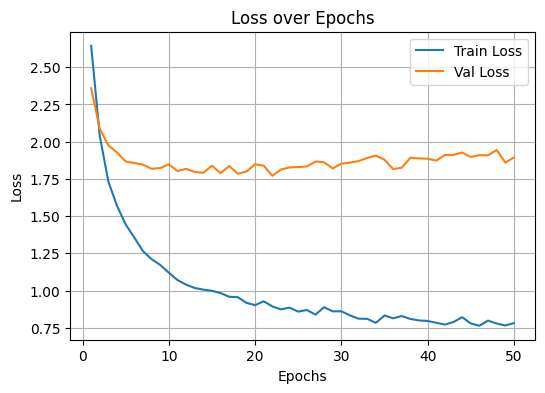

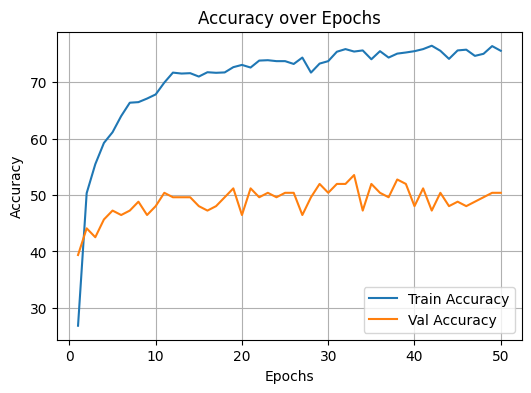

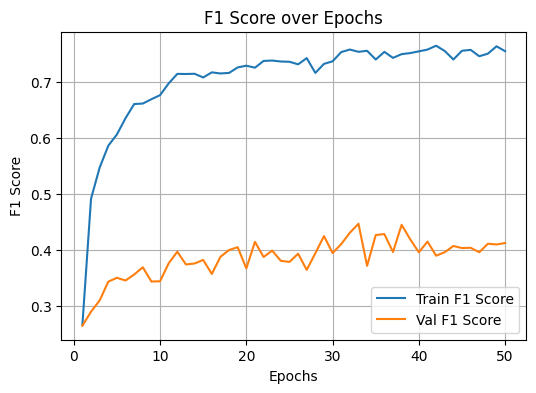

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="efficientnet_v2_m", use_hidden_layer=False, num_epochs=50)

#EfficientNetV2_M 1 hidden layer

[1/50] Train Loss: 2.3967 | Val Loss: 2.0500 | Train Acc: 29.53% | Val Acc: 42.52% | Train F1: 0.2891 | Val F1: 0.3061
[2/50] Train Loss: 1.5575 | Val Loss: 1.9120 | Train Acc: 53.13% | Val Acc: 44.09% | Train F1: 0.5256 | Val F1: 0.3295
[3/50] Train Loss: 1.2919 | Val Loss: 1.9736 | Train Acc: 60.67% | Val Acc: 47.24% | Train F1: 0.6020 | Val F1: 0.3887
[4/50] Train Loss: 1.1401 | Val Loss: 1.8026 | Train Acc: 64.67% | Val Acc: 44.88% | Train F1: 0.6440 | Val F1: 0.3455
[5/50] Train Loss: 1.0439 | Val Loss: 1.8833 | Train Acc: 67.77% | Val Acc: 48.82% | Train F1: 0.6758 | Val F1: 0.4092
[6/50] Train Loss: 1.0148 | Val Loss: 1.8323 | Train Acc: 68.50% | Val Acc: 53.54% | Train F1: 0.6839 | Val F1: 0.4501
[7/50] Train Loss: 0.9486 | Val Loss: 1.8618 | Train Acc: 71.10% | Val Acc: 44.88% | Train F1: 0.7086 | Val F1: 0.3309
[8/50] Train Loss: 0.8913 | Val Loss: 1.8305 | Train Acc: 72.10% | Val Acc: 51.97% | Train F1: 0.7195 | Val F1: 0.4334
[9/50] Train Loss: 0.8777 | Val Loss: 1.8495 | T

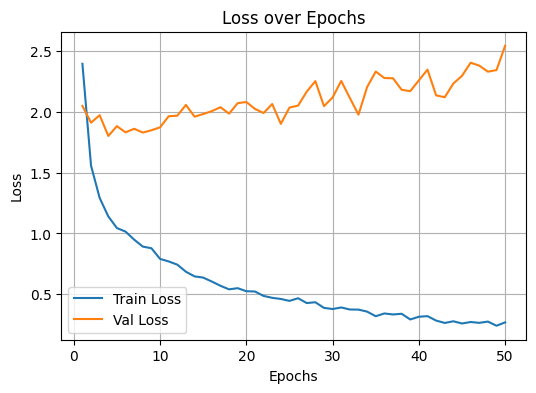

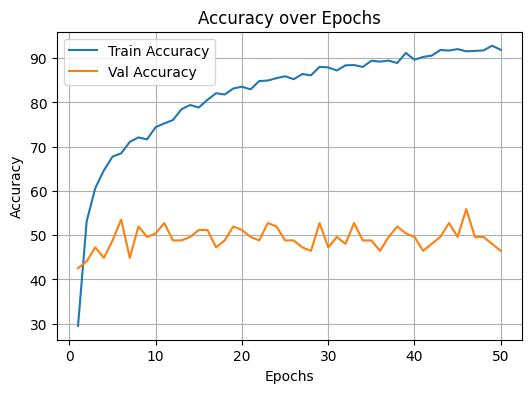

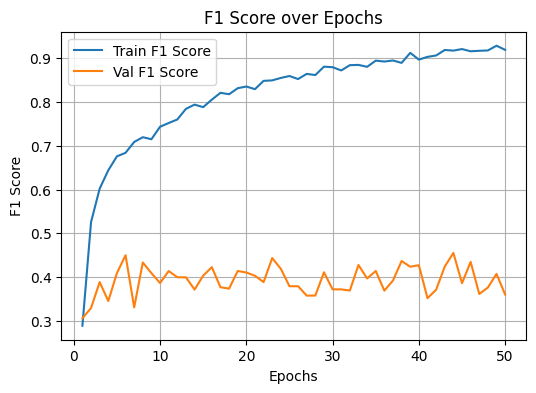

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="efficientnet_v2_m", use_hidden_layer=True, num_epochs=50)

#EfficientNetV2_L 0 hidden layer

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:08<00:00, 58.4MB/s]


[1/50] Train Loss: 2.2911 | Val Loss: 1.9069 | Train Acc: 34.40% | Val Acc: 51.18% | Train F1: 0.3441 | Val F1: 0.4182
[2/50] Train Loss: 1.4179 | Val Loss: 1.6080 | Train Acc: 63.17% | Val Acc: 54.33% | Train F1: 0.6265 | Val F1: 0.4700
[3/50] Train Loss: 1.1134 | Val Loss: 1.4711 | Train Acc: 70.17% | Val Acc: 58.27% | Train F1: 0.6989 | Val F1: 0.5090
[4/50] Train Loss: 0.9178 | Val Loss: 1.4397 | Train Acc: 75.33% | Val Acc: 60.63% | Train F1: 0.7516 | Val F1: 0.5430
[5/50] Train Loss: 0.8488 | Val Loss: 1.3798 | Train Acc: 77.10% | Val Acc: 61.42% | Train F1: 0.7693 | Val F1: 0.5558
[6/50] Train Loss: 0.7681 | Val Loss: 1.4292 | Train Acc: 78.10% | Val Acc: 58.27% | Train F1: 0.7795 | Val F1: 0.5191
[7/50] Train Loss: 0.6873 | Val Loss: 1.4208 | Train Acc: 81.03% | Val Acc: 58.27% | Train F1: 0.8098 | Val F1: 0.4976
[8/50] Train Loss: 0.6727 | Val Loss: 1.3929 | Train Acc: 80.50% | Val Acc: 60.63% | Train F1: 0.8038 | Val F1: 0.5345
[9/50] Train Loss: 0.6167 | Val Loss: 1.3155 | T

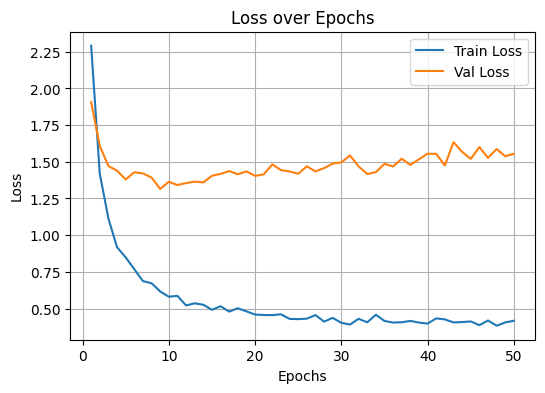

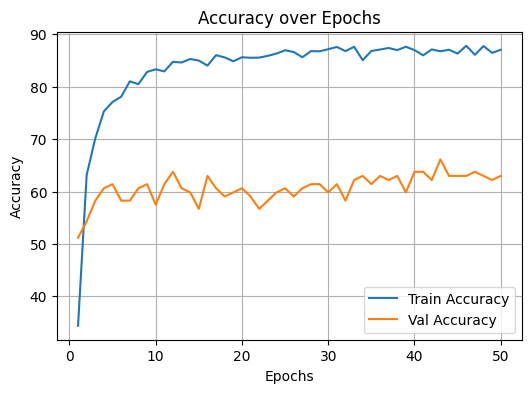

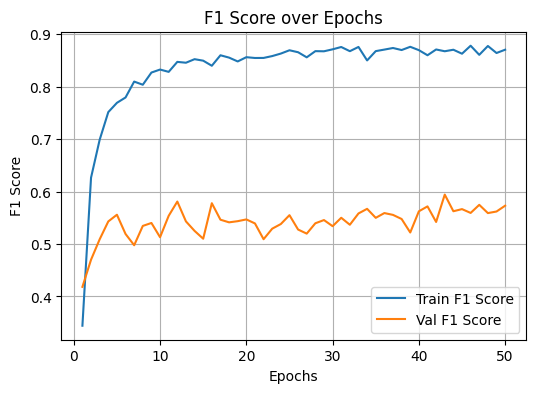

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="efficientnet_v2_l", use_hidden_layer=False, num_epochs=50)

#EfficientNetV2_L 1 hidden layer

[1/50] Train Loss: 2.0318 | Val Loss: 1.6637 | Train Acc: 41.50% | Val Acc: 56.69% | Train F1: 0.4124 | Val F1: 0.4827
[2/50] Train Loss: 1.0899 | Val Loss: 1.3805 | Train Acc: 67.97% | Val Acc: 59.84% | Train F1: 0.6775 | Val F1: 0.5282
[3/50] Train Loss: 0.8558 | Val Loss: 1.4815 | Train Acc: 73.47% | Val Acc: 55.91% | Train F1: 0.7340 | Val F1: 0.4939
[4/50] Train Loss: 0.7299 | Val Loss: 1.5180 | Train Acc: 76.83% | Val Acc: 58.27% | Train F1: 0.7670 | Val F1: 0.4869
[5/50] Train Loss: 0.7008 | Val Loss: 1.4648 | Train Acc: 78.00% | Val Acc: 60.63% | Train F1: 0.7794 | Val F1: 0.5227
[6/50] Train Loss: 0.6406 | Val Loss: 1.5328 | Train Acc: 80.67% | Val Acc: 59.84% | Train F1: 0.8062 | Val F1: 0.5346
[7/50] Train Loss: 0.5888 | Val Loss: 1.4636 | Train Acc: 80.83% | Val Acc: 62.20% | Train F1: 0.8078 | Val F1: 0.5559
[8/50] Train Loss: 0.5424 | Val Loss: 1.4860 | Train Acc: 82.60% | Val Acc: 62.20% | Train F1: 0.8255 | Val F1: 0.5323
[9/50] Train Loss: 0.5044 | Val Loss: 1.4071 | T

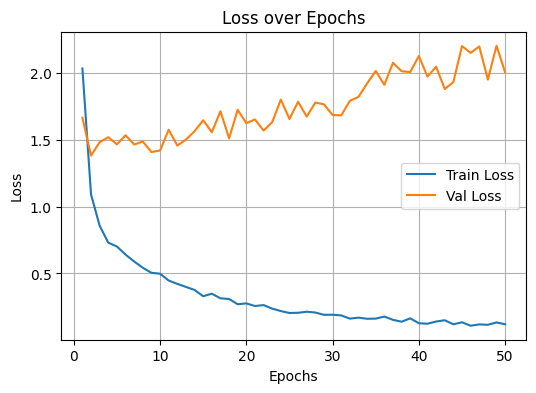

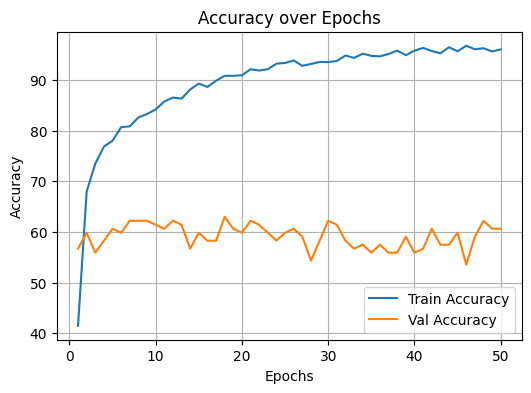

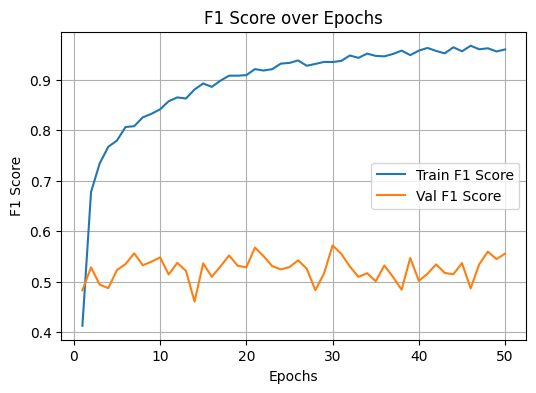

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="efficientnet_v2_l", use_hidden_layer=True, num_epochs=50)

#MobileNetV3_Small 0 hidden layer

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 81.6MB/s]


[1/50] Train Loss: 2.1433 | Val Loss: 2.0561 | Train Acc: 46.70% | Val Acc: 42.52% | Train F1: 0.4531 | Val F1: 0.3198
[2/50] Train Loss: 1.2354 | Val Loss: 1.6910 | Train Acc: 71.63% | Val Acc: 55.12% | Train F1: 0.7113 | Val F1: 0.4505
[3/50] Train Loss: 0.9122 | Val Loss: 1.5918 | Train Acc: 80.33% | Val Acc: 55.91% | Train F1: 0.8010 | Val F1: 0.4544
[4/50] Train Loss: 0.7307 | Val Loss: 1.5817 | Train Acc: 84.43% | Val Acc: 52.76% | Train F1: 0.8430 | Val F1: 0.4225
[5/50] Train Loss: 0.6259 | Val Loss: 1.5651 | Train Acc: 86.50% | Val Acc: 52.76% | Train F1: 0.8643 | Val F1: 0.4298
[6/50] Train Loss: 0.5425 | Val Loss: 1.5720 | Train Acc: 89.47% | Val Acc: 54.33% | Train F1: 0.8944 | Val F1: 0.4408
[7/50] Train Loss: 0.4829 | Val Loss: 1.5915 | Train Acc: 90.00% | Val Acc: 54.33% | Train F1: 0.8995 | Val F1: 0.4436
[8/50] Train Loss: 0.4254 | Val Loss: 1.6136 | Train Acc: 91.77% | Val Acc: 54.33% | Train F1: 0.9176 | Val F1: 0.4489
[9/50] Train Loss: 0.3838 | Val Loss: 1.6222 | T

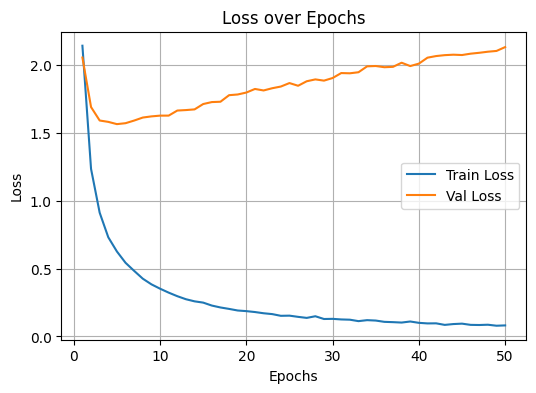

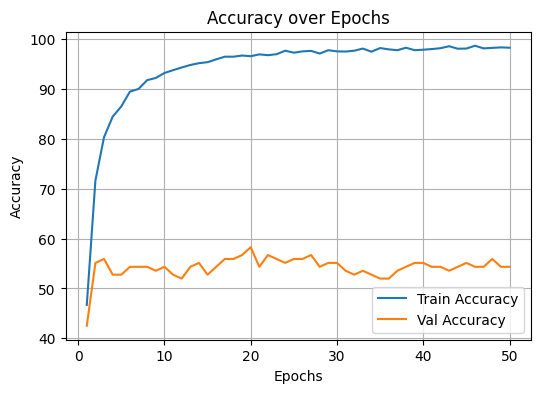

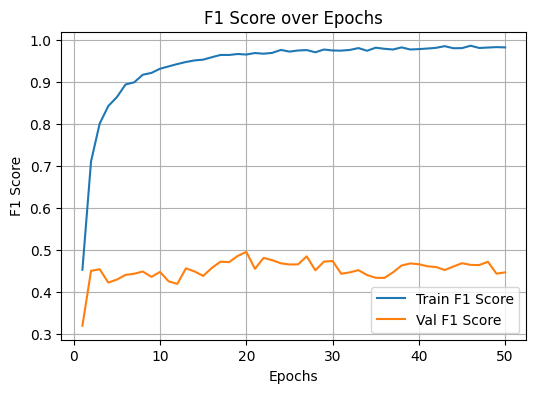

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="mobilenet_v3_small", use_hidden_layer=False, num_epochs=50)

#MobileNetV3_Small 1 hidden layer

[1/50] Train Loss: 1.6586 | Val Loss: 1.8495 | Train Acc: 54.73% | Val Acc: 48.03% | Train F1: 0.5386 | Val F1: 0.4073
[2/50] Train Loss: 0.5634 | Val Loss: 1.6894 | Train Acc: 84.60% | Val Acc: 48.82% | Train F1: 0.8455 | Val F1: 0.4176
[3/50] Train Loss: 0.2969 | Val Loss: 1.7873 | Train Acc: 92.30% | Val Acc: 54.33% | Train F1: 0.9230 | Val F1: 0.4613
[4/50] Train Loss: 0.1759 | Val Loss: 1.7000 | Train Acc: 95.90% | Val Acc: 59.06% | Train F1: 0.9589 | Val F1: 0.5178
[5/50] Train Loss: 0.1427 | Val Loss: 2.0140 | Train Acc: 95.97% | Val Acc: 55.12% | Train F1: 0.9596 | Val F1: 0.4637
[6/50] Train Loss: 0.1006 | Val Loss: 2.0545 | Train Acc: 97.87% | Val Acc: 55.12% | Train F1: 0.9787 | Val F1: 0.4326
[7/50] Train Loss: 0.0771 | Val Loss: 2.1263 | Train Acc: 98.40% | Val Acc: 58.27% | Train F1: 0.9840 | Val F1: 0.4825
[8/50] Train Loss: 0.0748 | Val Loss: 2.0856 | Train Acc: 98.17% | Val Acc: 52.76% | Train F1: 0.9817 | Val F1: 0.4450
[9/50] Train Loss: 0.0547 | Val Loss: 2.1089 | T

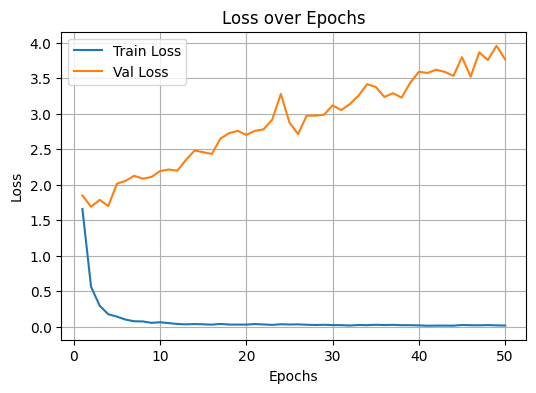

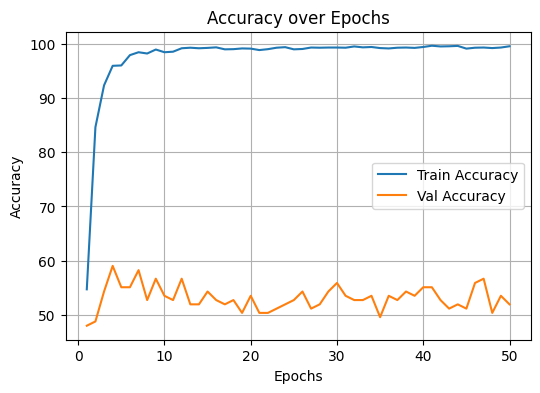

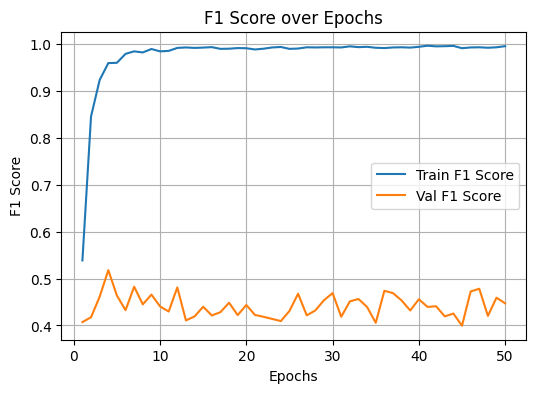

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="mobilenet_v3_small", use_hidden_layer=True, num_epochs=50)

#MobileNetV3_Large 0 hidden layer

[1/50] Train Loss: 1.9591 | Val Loss: 2.0737 | Train Acc: 51.57% | Val Acc: 39.37% | Train F1: 0.5073 | Val F1: 0.3144
[2/50] Train Loss: 1.0093 | Val Loss: 1.6409 | Train Acc: 78.53% | Val Acc: 57.48% | Train F1: 0.7828 | Val F1: 0.5004
[3/50] Train Loss: 0.6918 | Val Loss: 1.5997 | Train Acc: 86.90% | Val Acc: 58.27% | Train F1: 0.8679 | Val F1: 0.5150
[4/50] Train Loss: 0.5301 | Val Loss: 1.6294 | Train Acc: 89.83% | Val Acc: 56.69% | Train F1: 0.8977 | Val F1: 0.5019
[5/50] Train Loss: 0.4221 | Val Loss: 1.6344 | Train Acc: 93.60% | Val Acc: 57.48% | Train F1: 0.9360 | Val F1: 0.5040
[6/50] Train Loss: 0.3549 | Val Loss: 1.6725 | Train Acc: 94.23% | Val Acc: 55.91% | Train F1: 0.9422 | Val F1: 0.4753
[7/50] Train Loss: 0.3079 | Val Loss: 1.6876 | Train Acc: 94.93% | Val Acc: 55.12% | Train F1: 0.9492 | Val F1: 0.4697
[8/50] Train Loss: 0.2644 | Val Loss: 1.7208 | Train Acc: 96.03% | Val Acc: 55.12% | Train F1: 0.9602 | Val F1: 0.4809
[9/50] Train Loss: 0.2301 | Val Loss: 1.7500 | T

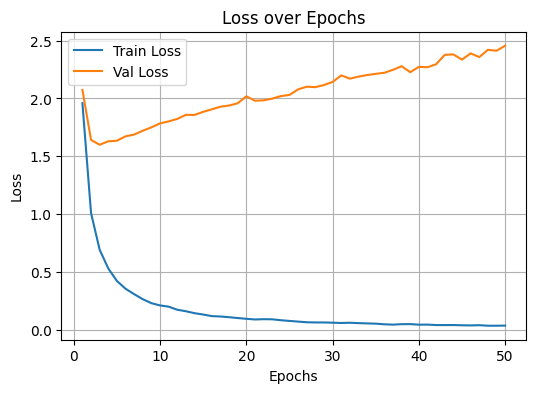

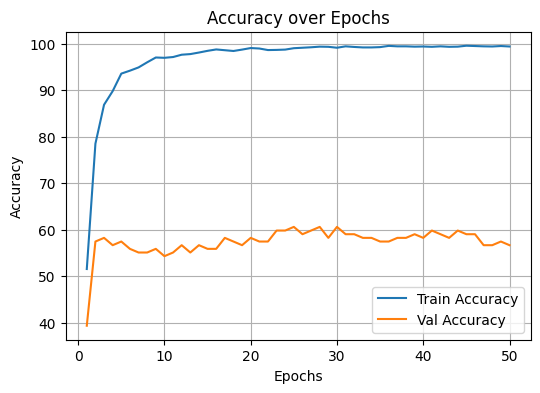

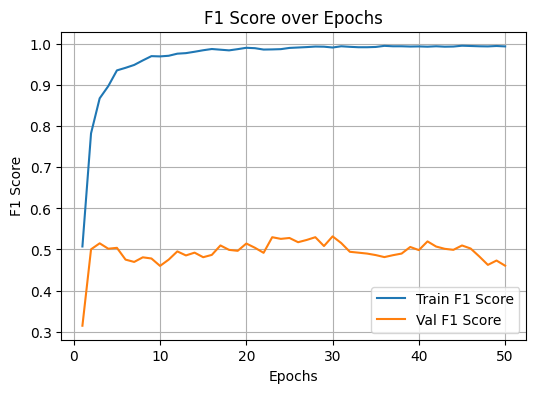

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="mobilenet_v3_large", use_hidden_layer=False, num_epochs=50)

#MobileNetV3_Large 1 hidden layer

[1/50] Train Loss: 1.5115 | Val Loss: 1.8982 | Train Acc: 60.07% | Val Acc: 44.09% | Train F1: 0.5984 | Val F1: 0.3344
[2/50] Train Loss: 0.4113 | Val Loss: 1.6484 | Train Acc: 88.60% | Val Acc: 55.91% | Train F1: 0.8856 | Val F1: 0.4936
[3/50] Train Loss: 0.1773 | Val Loss: 1.8806 | Train Acc: 96.27% | Val Acc: 55.91% | Train F1: 0.9627 | Val F1: 0.4949
[4/50] Train Loss: 0.1104 | Val Loss: 2.1290 | Train Acc: 97.60% | Val Acc: 55.12% | Train F1: 0.9760 | Val F1: 0.4713
[5/50] Train Loss: 0.0744 | Val Loss: 2.1422 | Train Acc: 98.27% | Val Acc: 57.48% | Train F1: 0.9827 | Val F1: 0.4985
[6/50] Train Loss: 0.0487 | Val Loss: 2.1529 | Train Acc: 99.10% | Val Acc: 61.42% | Train F1: 0.9910 | Val F1: 0.5478
[7/50] Train Loss: 0.0465 | Val Loss: 2.3611 | Train Acc: 99.10% | Val Acc: 57.48% | Train F1: 0.9910 | Val F1: 0.4882
[8/50] Train Loss: 0.0378 | Val Loss: 2.3579 | Train Acc: 99.23% | Val Acc: 54.33% | Train F1: 0.9923 | Val F1: 0.4717
[9/50] Train Loss: 0.0364 | Val Loss: 2.4322 | T

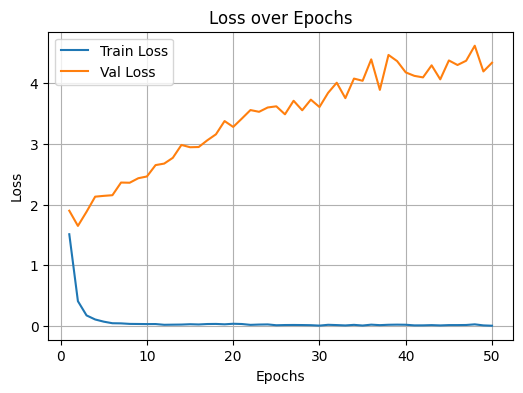

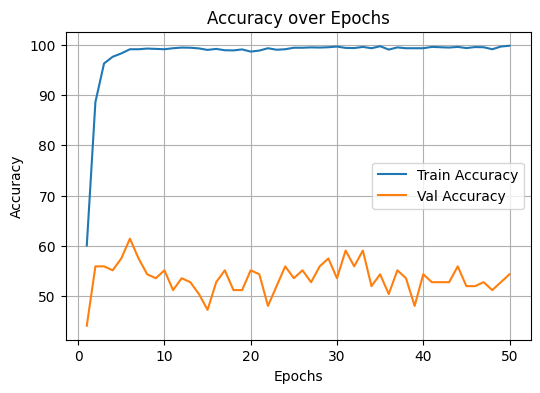

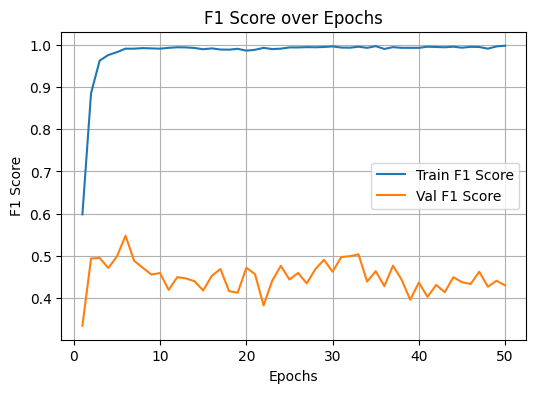

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="mobilenet_v3_large", use_hidden_layer=True, num_epochs=50)

#ResNeSt50 0 hidden layer

Downloading: "https://github.com/zhanghang1989/ResNeSt/releases/download/weights_step1/resnest50-528c19ca.pth" to /root/.cache/torch/hub/checkpoints/resnest50-528c19ca.pth
100%|██████████| 105M/105M [00:11<00:00, 9.81MB/s]


[1/50] Train Loss: 2.2105 | Val Loss: 2.1120 | Train Acc: 37.40% | Val Acc: 40.94% | Train F1: 0.3664 | Val F1: 0.2947
[2/50] Train Loss: 1.3079 | Val Loss: 1.8914 | Train Acc: 66.27% | Val Acc: 42.52% | Train F1: 0.6589 | Val F1: 0.3055
[3/50] Train Loss: 0.9478 | Val Loss: 1.8123 | Train Acc: 76.67% | Val Acc: 46.46% | Train F1: 0.7648 | Val F1: 0.3513
[4/50] Train Loss: 0.7444 | Val Loss: 1.7157 | Train Acc: 84.37% | Val Acc: 48.82% | Train F1: 0.8426 | Val F1: 0.3919
[5/50] Train Loss: 0.5990 | Val Loss: 1.7441 | Train Acc: 88.17% | Val Acc: 50.39% | Train F1: 0.8813 | Val F1: 0.4026
[6/50] Train Loss: 0.4966 | Val Loss: 1.7072 | Train Acc: 90.77% | Val Acc: 51.97% | Train F1: 0.9075 | Val F1: 0.4187
[7/50] Train Loss: 0.4226 | Val Loss: 1.6716 | Train Acc: 92.50% | Val Acc: 48.82% | Train F1: 0.9248 | Val F1: 0.3916
[8/50] Train Loss: 0.3590 | Val Loss: 1.6916 | Train Acc: 94.70% | Val Acc: 52.76% | Train F1: 0.9468 | Val F1: 0.4358
[9/50] Train Loss: 0.3310 | Val Loss: 1.6755 | T

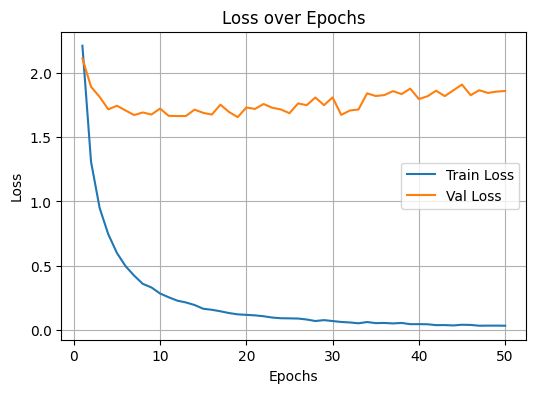

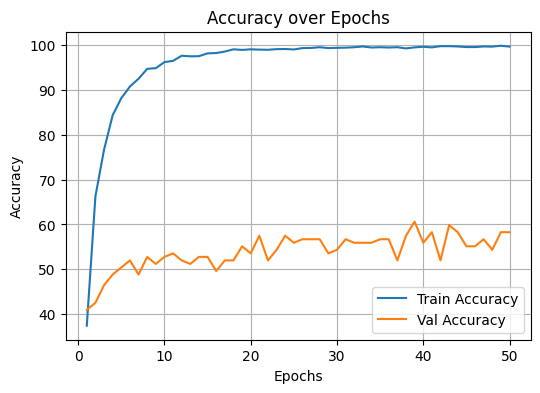

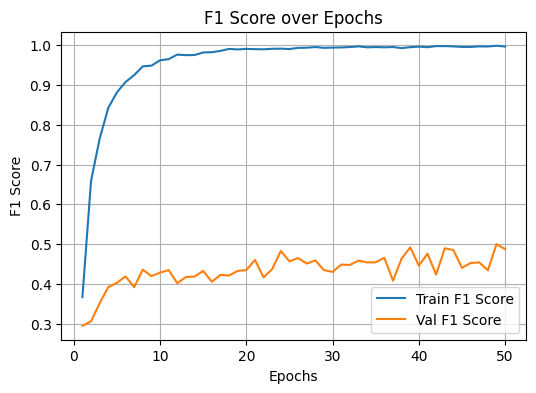

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="resnest50", use_hidden_layer=False, num_epochs=50)

#ResNeSt50 1 hidden layer

[1/50] Train Loss: 2.0859 | Val Loss: 2.0393 | Train Acc: 38.23% | Val Acc: 40.94% | Train F1: 0.3798 | Val F1: 0.2980
[2/50] Train Loss: 0.9824 | Val Loss: 1.7548 | Train Acc: 70.70% | Val Acc: 53.54% | Train F1: 0.7047 | Val F1: 0.4293
[3/50] Train Loss: 0.6024 | Val Loss: 1.6481 | Train Acc: 83.43% | Val Acc: 54.33% | Train F1: 0.8335 | Val F1: 0.4458
[4/50] Train Loss: 0.3583 | Val Loss: 1.8186 | Train Acc: 90.13% | Val Acc: 52.76% | Train F1: 0.9012 | Val F1: 0.4585
[5/50] Train Loss: 0.2715 | Val Loss: 1.7236 | Train Acc: 92.80% | Val Acc: 48.82% | Train F1: 0.9279 | Val F1: 0.3993
[6/50] Train Loss: 0.2191 | Val Loss: 1.8062 | Train Acc: 94.13% | Val Acc: 51.18% | Train F1: 0.9413 | Val F1: 0.3872
[7/50] Train Loss: 0.1405 | Val Loss: 1.8346 | Train Acc: 96.60% | Val Acc: 48.03% | Train F1: 0.9660 | Val F1: 0.4031
[8/50] Train Loss: 0.1217 | Val Loss: 1.8915 | Train Acc: 97.07% | Val Acc: 55.91% | Train F1: 0.9706 | Val F1: 0.4447
[9/50] Train Loss: 0.1251 | Val Loss: 2.1018 | T

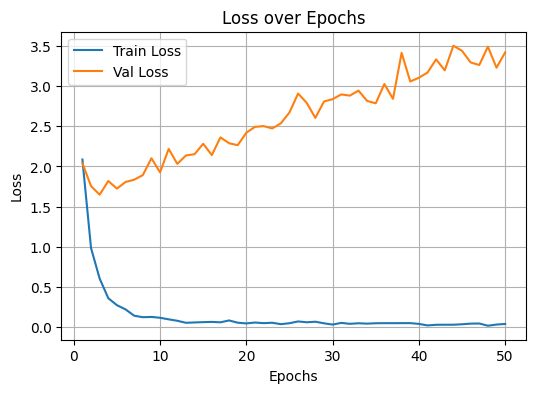

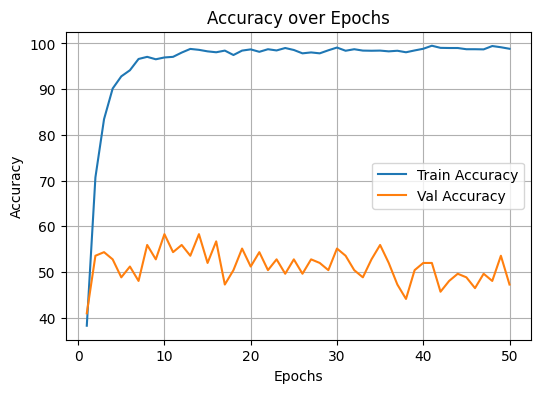

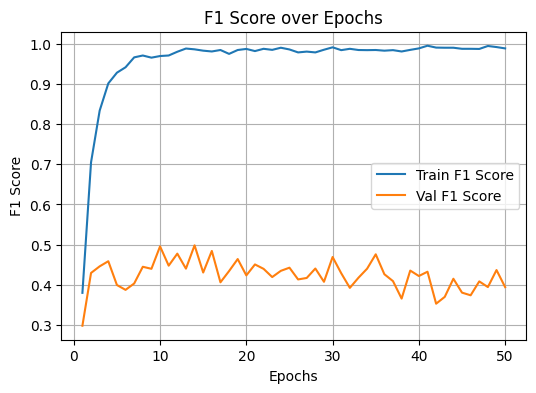

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="resnest50", use_hidden_layer=True, num_epochs=50)

#ResNeSt101 0 hidden layer

Downloading: "https://github.com/zhanghang1989/ResNeSt/releases/download/weights_step1/resnest101-22405ba7.pth" to /root/.cache/torch/hub/checkpoints/resnest101-22405ba7.pth
100%|██████████| 185M/185M [00:17<00:00, 11.4MB/s]


[1/50] Train Loss: 2.2092 | Val Loss: 2.1186 | Train Acc: 37.37% | Val Acc: 41.73% | Train F1: 0.3690 | Val F1: 0.3061
[2/50] Train Loss: 1.2657 | Val Loss: 1.9562 | Train Acc: 68.27% | Val Acc: 40.94% | Train F1: 0.6800 | Val F1: 0.3169
[3/50] Train Loss: 0.9399 | Val Loss: 1.9136 | Train Acc: 78.57% | Val Acc: 48.82% | Train F1: 0.7840 | Val F1: 0.3713
[4/50] Train Loss: 0.7433 | Val Loss: 1.9116 | Train Acc: 83.83% | Val Acc: 48.82% | Train F1: 0.8373 | Val F1: 0.3598
[5/50] Train Loss: 0.5941 | Val Loss: 1.8973 | Train Acc: 87.97% | Val Acc: 52.76% | Train F1: 0.8789 | Val F1: 0.4200
[6/50] Train Loss: 0.4904 | Val Loss: 1.8673 | Train Acc: 90.37% | Val Acc: 51.97% | Train F1: 0.9031 | Val F1: 0.3983
[7/50] Train Loss: 0.4140 | Val Loss: 1.8883 | Train Acc: 92.80% | Val Acc: 49.61% | Train F1: 0.9276 | Val F1: 0.3508
[8/50] Train Loss: 0.3547 | Val Loss: 1.8893 | Train Acc: 94.67% | Val Acc: 48.82% | Train F1: 0.9465 | Val F1: 0.3612
[9/50] Train Loss: 0.3225 | Val Loss: 1.9074 | T

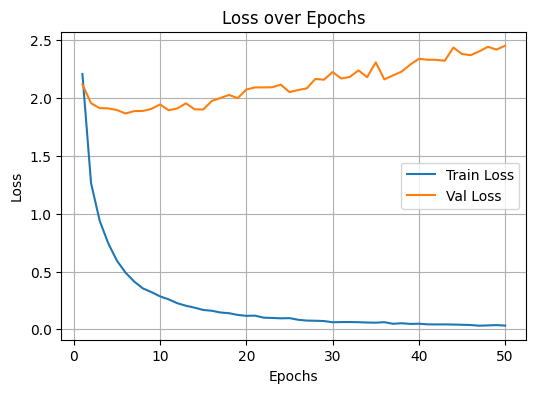

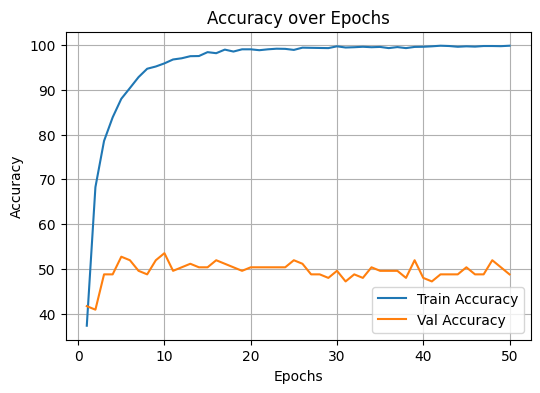

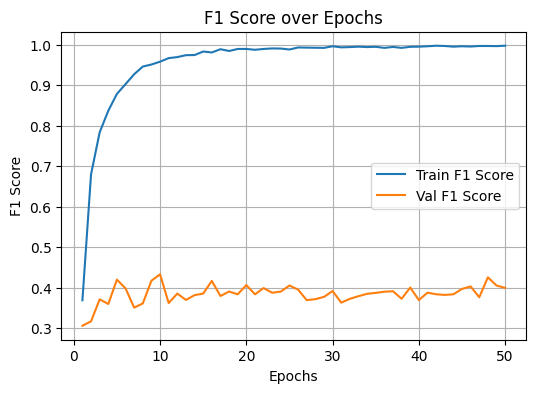

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="resnest101", use_hidden_layer=False, num_epochs=50)

#ResNeSt101 1 hidden layer

[1/50] Train Loss: 2.0199 | Val Loss: 2.1196 | Train Acc: 40.03% | Val Acc: 40.16% | Train F1: 0.3979 | Val F1: 0.2716
[2/50] Train Loss: 0.9281 | Val Loss: 2.1287 | Train Acc: 72.77% | Val Acc: 43.31% | Train F1: 0.7263 | Val F1: 0.3504
[3/50] Train Loss: 0.5213 | Val Loss: 2.0545 | Train Acc: 85.07% | Val Acc: 46.46% | Train F1: 0.8503 | Val F1: 0.3548
[4/50] Train Loss: 0.3325 | Val Loss: 2.0571 | Train Acc: 90.97% | Val Acc: 49.61% | Train F1: 0.9093 | Val F1: 0.3756
[5/50] Train Loss: 0.2653 | Val Loss: 2.0960 | Train Acc: 92.23% | Val Acc: 50.39% | Train F1: 0.9223 | Val F1: 0.4002
[6/50] Train Loss: 0.1891 | Val Loss: 2.4655 | Train Acc: 94.90% | Val Acc: 44.09% | Train F1: 0.9488 | Val F1: 0.3342
[7/50] Train Loss: 0.1520 | Val Loss: 2.3468 | Train Acc: 95.63% | Val Acc: 49.61% | Train F1: 0.9563 | Val F1: 0.3869
[8/50] Train Loss: 0.1163 | Val Loss: 2.6464 | Train Acc: 97.23% | Val Acc: 48.82% | Train F1: 0.9723 | Val F1: 0.3399
[9/50] Train Loss: 0.1077 | Val Loss: 2.4109 | T

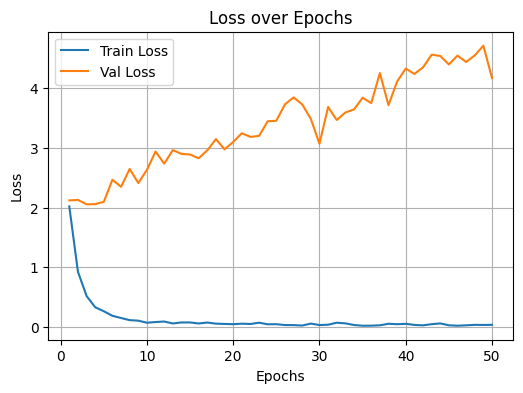

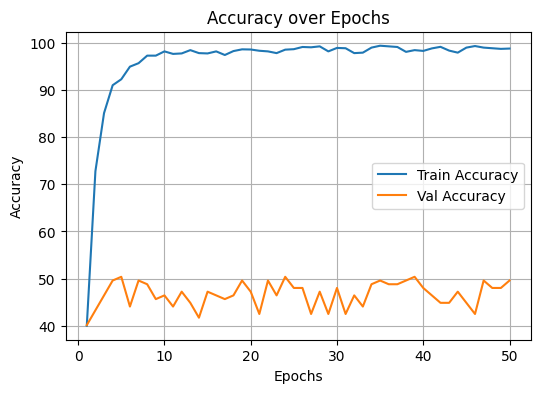

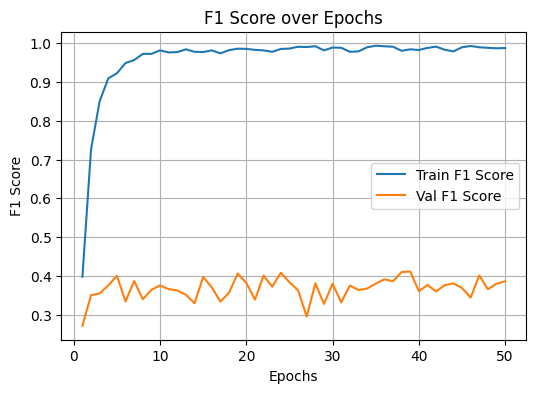

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="resnest101", use_hidden_layer=True, num_epochs=50)

#ResNeSt200 0 hidden layer

Downloading: "https://github.com/zhanghang1989/ResNeSt/releases/download/weights_step1/resnest200-75117900.pth" to /root/.cache/torch/hub/checkpoints/resnest200-75117900.pth
100%|██████████| 269M/269M [00:29<00:00, 9.42MB/s]


[1/50] Train Loss: 2.2035 | Val Loss: 1.9776 | Train Acc: 37.03% | Val Acc: 36.22% | Train F1: 0.3706 | Val F1: 0.2745
[2/50] Train Loss: 1.2948 | Val Loss: 1.7736 | Train Acc: 64.97% | Val Acc: 45.67% | Train F1: 0.6454 | Val F1: 0.3618
[3/50] Train Loss: 0.9742 | Val Loss: 1.7262 | Train Acc: 75.70% | Val Acc: 47.24% | Train F1: 0.7557 | Val F1: 0.3409
[4/50] Train Loss: 0.7993 | Val Loss: 1.6958 | Train Acc: 80.13% | Val Acc: 51.97% | Train F1: 0.7998 | Val F1: 0.4183
[5/50] Train Loss: 0.6575 | Val Loss: 1.7146 | Train Acc: 84.70% | Val Acc: 50.39% | Train F1: 0.8463 | Val F1: 0.3955
[6/50] Train Loss: 0.5711 | Val Loss: 1.6884 | Train Acc: 87.07% | Val Acc: 46.46% | Train F1: 0.8704 | Val F1: 0.3730
[7/50] Train Loss: 0.5014 | Val Loss: 1.7111 | Train Acc: 88.47% | Val Acc: 47.24% | Train F1: 0.8845 | Val F1: 0.3661
[8/50] Train Loss: 0.4456 | Val Loss: 1.6887 | Train Acc: 90.67% | Val Acc: 49.61% | Train F1: 0.9064 | Val F1: 0.3876
[9/50] Train Loss: 0.3871 | Val Loss: 1.7177 | T

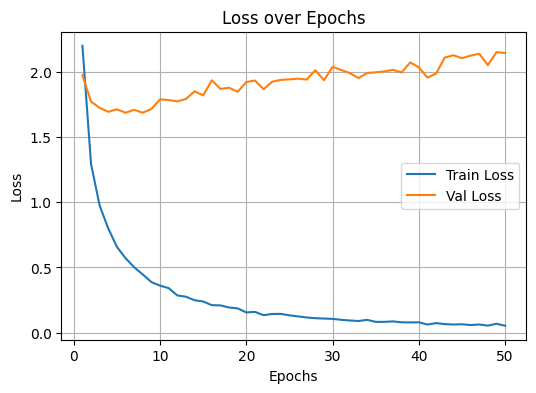

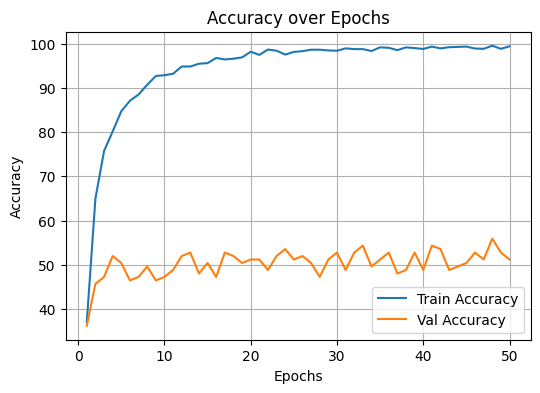

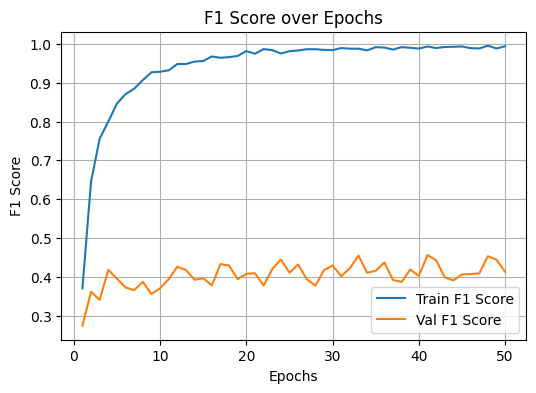

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="resnest200", use_hidden_layer=False, num_epochs=50)

#ResNeSt200 1 hidden layer

[1/50] Train Loss: 2.0799 | Val Loss: 1.9328 | Train Acc: 38.43% | Val Acc: 39.37% | Train F1: 0.3784 | Val F1: 0.2881
[2/50] Train Loss: 1.1001 | Val Loss: 1.7559 | Train Acc: 66.80% | Val Acc: 42.52% | Train F1: 0.6666 | Val F1: 0.3584
[3/50] Train Loss: 0.6985 | Val Loss: 1.7107 | Train Acc: 78.67% | Val Acc: 51.18% | Train F1: 0.7855 | Val F1: 0.3907
[4/50] Train Loss: 0.4759 | Val Loss: 1.8154 | Train Acc: 86.43% | Val Acc: 51.97% | Train F1: 0.8639 | Val F1: 0.3875
[5/50] Train Loss: 0.3701 | Val Loss: 1.9543 | Train Acc: 89.50% | Val Acc: 51.18% | Train F1: 0.8950 | Val F1: 0.4014
[6/50] Train Loss: 0.2878 | Val Loss: 2.1841 | Train Acc: 91.90% | Val Acc: 47.24% | Train F1: 0.9189 | Val F1: 0.4104
[7/50] Train Loss: 0.2180 | Val Loss: 1.9599 | Train Acc: 93.83% | Val Acc: 47.24% | Train F1: 0.9383 | Val F1: 0.3837
[8/50] Train Loss: 0.1969 | Val Loss: 2.0367 | Train Acc: 94.53% | Val Acc: 53.54% | Train F1: 0.9452 | Val F1: 0.4577
[9/50] Train Loss: 0.1959 | Val Loss: 2.1969 | T

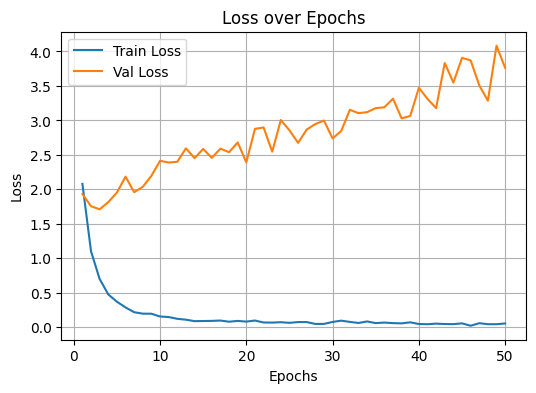

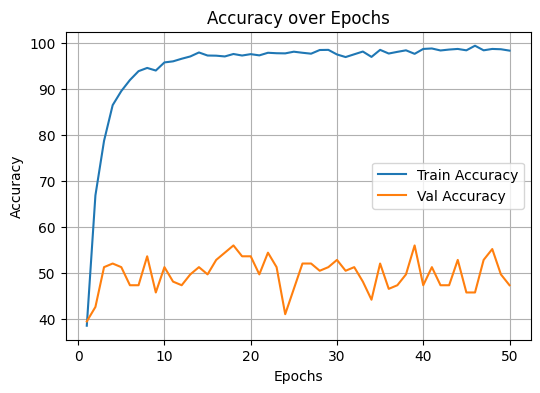

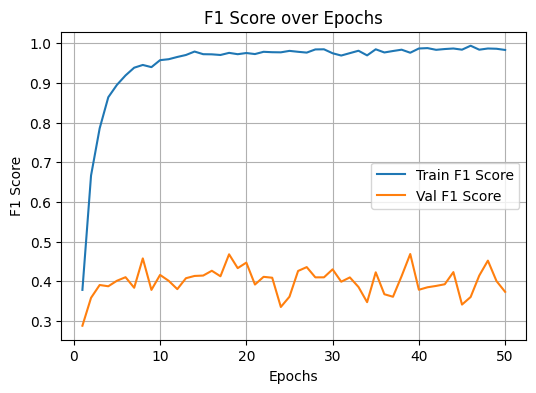

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="resnest200", use_hidden_layer=True, num_epochs=50)

#ResNeSt269 1 hidden layer

Downloading: "https://github.com/zhanghang1989/ResNeSt/releases/download/weights_step1/resnest269-0cc87c48.pth" to /root/.cache/torch/hub/checkpoints/resnest269-0cc87c48.pth
100%|██████████| 425M/425M [00:15<00:00, 29.4MB/s]


[1/50] Train Loss: 2.2625 | Val Loss: 2.1107 | Train Acc: 34.97% | Val Acc: 35.43% | Train F1: 0.3456 | Val F1: 0.2143
[2/50] Train Loss: 1.3292 | Val Loss: 1.9383 | Train Acc: 64.60% | Val Acc: 44.09% | Train F1: 0.6418 | Val F1: 0.3091
[3/50] Train Loss: 1.0036 | Val Loss: 1.8266 | Train Acc: 74.83% | Val Acc: 42.52% | Train F1: 0.7463 | Val F1: 0.3010
[4/50] Train Loss: 0.7956 | Val Loss: 1.8924 | Train Acc: 80.37% | Val Acc: 49.61% | Train F1: 0.8024 | Val F1: 0.3704
[5/50] Train Loss: 0.6864 | Val Loss: 1.8145 | Train Acc: 82.70% | Val Acc: 46.46% | Train F1: 0.8264 | Val F1: 0.3479
[6/50] Train Loss: 0.6034 | Val Loss: 1.9818 | Train Acc: 85.20% | Val Acc: 44.88% | Train F1: 0.8515 | Val F1: 0.3315
[7/50] Train Loss: 0.5141 | Val Loss: 1.9482 | Train Acc: 88.17% | Val Acc: 45.67% | Train F1: 0.8814 | Val F1: 0.3265
[8/50] Train Loss: 0.4615 | Val Loss: 2.0884 | Train Acc: 90.20% | Val Acc: 47.24% | Train F1: 0.9017 | Val F1: 0.3422
[9/50] Train Loss: 0.3955 | Val Loss: 2.0161 | T

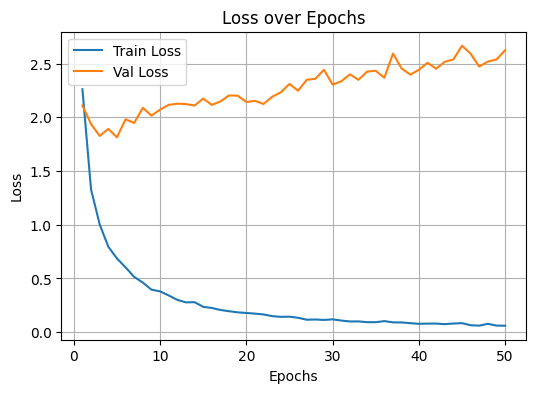

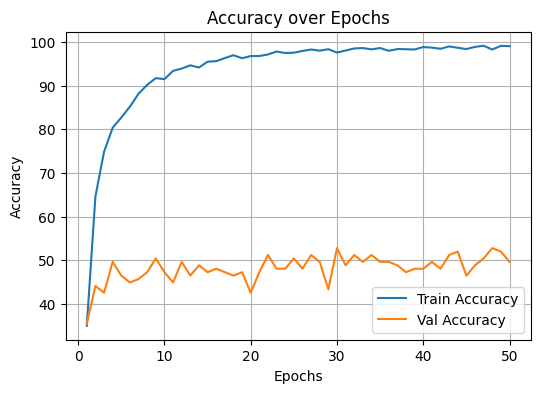

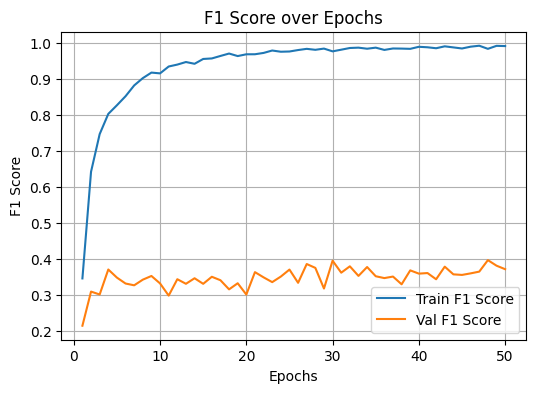

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="resnest269", use_hidden_layer=False, num_epochs=50)

#ResNeSt269 0 hidden layer

[1/50] Train Loss: 2.1292 | Val Loss: 2.2563 | Train Acc: 37.27% | Val Acc: 36.22% | Train F1: 0.3653 | Val F1: 0.2449
[2/50] Train Loss: 1.1081 | Val Loss: 2.1132 | Train Acc: 65.47% | Val Acc: 44.88% | Train F1: 0.6544 | Val F1: 0.3023
[3/50] Train Loss: 0.7233 | Val Loss: 2.1540 | Train Acc: 78.73% | Val Acc: 51.97% | Train F1: 0.7855 | Val F1: 0.3752
[4/50] Train Loss: 0.5840 | Val Loss: 2.1533 | Train Acc: 81.90% | Val Acc: 47.24% | Train F1: 0.8187 | Val F1: 0.3676
[5/50] Train Loss: 0.4391 | Val Loss: 2.2216 | Train Acc: 86.77% | Val Acc: 44.09% | Train F1: 0.8675 | Val F1: 0.3282
[6/50] Train Loss: 0.3320 | Val Loss: 2.2798 | Train Acc: 90.10% | Val Acc: 46.46% | Train F1: 0.9006 | Val F1: 0.3305
[7/50] Train Loss: 0.2672 | Val Loss: 2.4899 | Train Acc: 91.93% | Val Acc: 43.31% | Train F1: 0.9193 | Val F1: 0.3139
[8/50] Train Loss: 0.2259 | Val Loss: 2.5330 | Train Acc: 93.43% | Val Acc: 44.09% | Train F1: 0.9343 | Val F1: 0.3190
[9/50] Train Loss: 0.2320 | Val Loss: 2.4758 | T

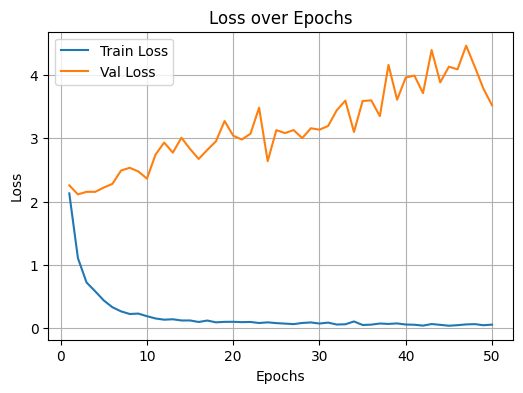

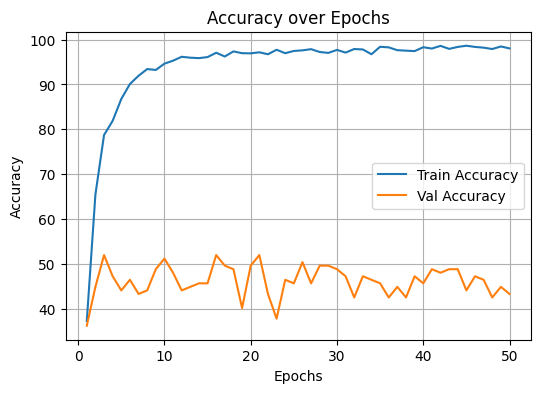

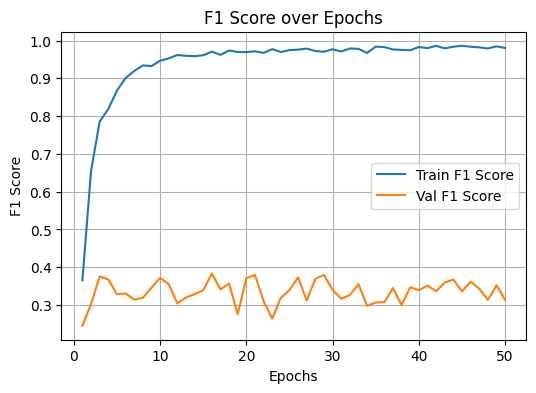

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="resnest269", use_hidden_layer=True, num_epochs=50)

#ResNet34 0 hidden layer

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 182MB/s]


[1/50] Train Loss: 2.5297 | Val Loss: 2.2514 | Train Acc: 26.30% | Val Acc: 36.22% | Train F1: 0.2613 | Val F1: 0.2768
[2/50] Train Loss: 1.7045 | Val Loss: 1.9638 | Train Acc: 56.03% | Val Acc: 40.94% | Train F1: 0.5523 | Val F1: 0.3290
[3/50] Train Loss: 1.3397 | Val Loss: 1.8420 | Train Acc: 66.10% | Val Acc: 48.03% | Train F1: 0.6572 | Val F1: 0.3801
[4/50] Train Loss: 1.1291 | Val Loss: 1.8306 | Train Acc: 71.93% | Val Acc: 49.61% | Train F1: 0.7168 | Val F1: 0.3865
[5/50] Train Loss: 0.9836 | Val Loss: 1.7396 | Train Acc: 75.20% | Val Acc: 49.61% | Train F1: 0.7486 | Val F1: 0.3992
[6/50] Train Loss: 0.9075 | Val Loss: 1.8209 | Train Acc: 76.03% | Val Acc: 50.39% | Train F1: 0.7584 | Val F1: 0.3979
[7/50] Train Loss: 0.8051 | Val Loss: 1.7651 | Train Acc: 78.77% | Val Acc: 50.39% | Train F1: 0.7860 | Val F1: 0.3903
[8/50] Train Loss: 0.7385 | Val Loss: 1.8341 | Train Acc: 81.93% | Val Acc: 50.39% | Train F1: 0.8185 | Val F1: 0.3812
[9/50] Train Loss: 0.6945 | Val Loss: 1.7676 | T

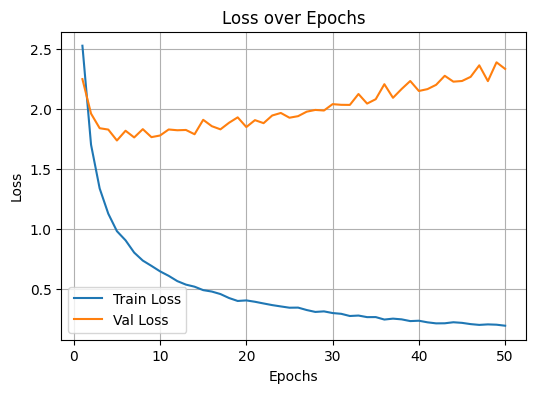

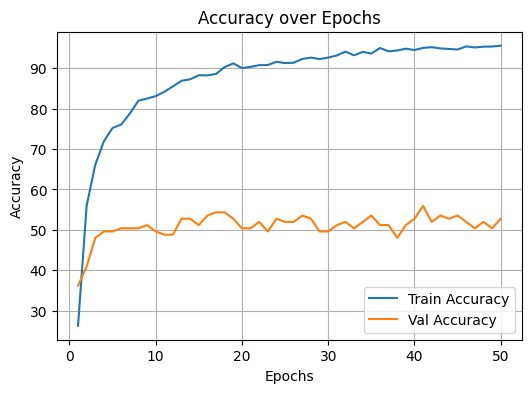

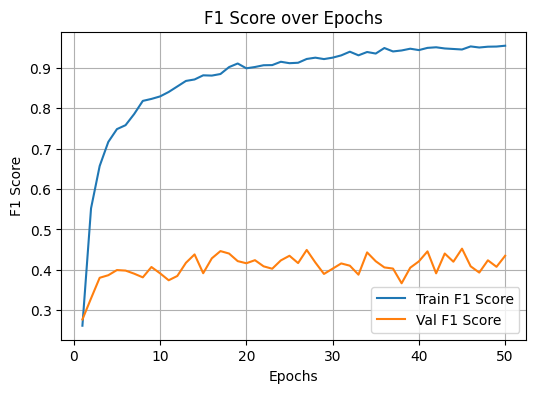

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="resnet34", use_hidden_layer=False, num_epochs=50)

#ResNet34 1 hidden layer

[1/50] Train Loss: 2.1943 | Val Loss: 1.9988 | Train Acc: 35.13% | Val Acc: 44.88% | Train F1: 0.3510 | Val F1: 0.3567
[2/50] Train Loss: 1.2216 | Val Loss: 1.9843 | Train Acc: 63.43% | Val Acc: 45.67% | Train F1: 0.6292 | Val F1: 0.3398
[3/50] Train Loss: 0.8823 | Val Loss: 1.9059 | Train Acc: 73.97% | Val Acc: 49.61% | Train F1: 0.7371 | Val F1: 0.4149
[4/50] Train Loss: 0.7240 | Val Loss: 2.1125 | Train Acc: 77.63% | Val Acc: 50.39% | Train F1: 0.7752 | Val F1: 0.3950
[5/50] Train Loss: 0.5956 | Val Loss: 2.1254 | Train Acc: 82.77% | Val Acc: 49.61% | Train F1: 0.8264 | Val F1: 0.3947
[6/50] Train Loss: 0.5091 | Val Loss: 2.1931 | Train Acc: 84.37% | Val Acc: 48.03% | Train F1: 0.8431 | Val F1: 0.3655
[7/50] Train Loss: 0.4518 | Val Loss: 2.1935 | Train Acc: 85.70% | Val Acc: 51.97% | Train F1: 0.8564 | Val F1: 0.4103
[8/50] Train Loss: 0.3936 | Val Loss: 2.0693 | Train Acc: 87.53% | Val Acc: 54.33% | Train F1: 0.8751 | Val F1: 0.4345
[9/50] Train Loss: 0.3228 | Val Loss: 2.2465 | T

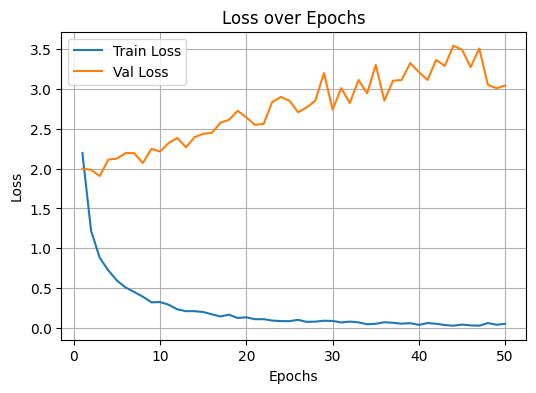

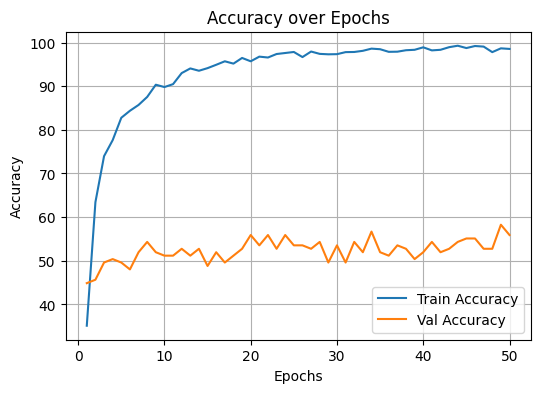

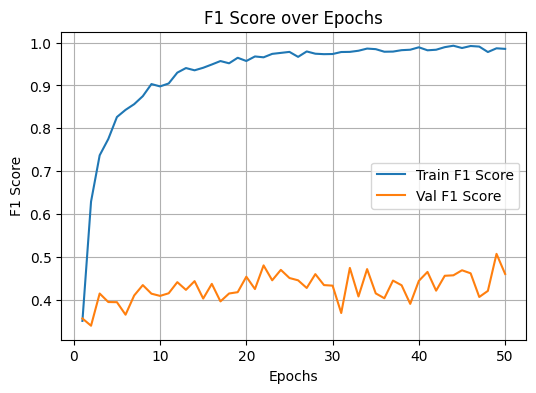

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="resnet34", use_hidden_layer=True, num_epochs=50)

#ResNet50 0 hidden layer

[1/50] Train Loss: 2.3771 | Val Loss: 2.0499 | Train Acc: 34.07% | Val Acc: 37.01% | Train F1: 0.3363 | Val F1: 0.2661
[2/50] Train Loss: 1.4480 | Val Loss: 1.8451 | Train Acc: 62.33% | Val Acc: 44.09% | Train F1: 0.6174 | Val F1: 0.3139
[3/50] Train Loss: 1.1341 | Val Loss: 1.7610 | Train Acc: 70.17% | Val Acc: 46.46% | Train F1: 0.6983 | Val F1: 0.3469
[4/50] Train Loss: 0.9628 | Val Loss: 1.7429 | Train Acc: 74.20% | Val Acc: 43.31% | Train F1: 0.7404 | Val F1: 0.3123
[5/50] Train Loss: 0.8078 | Val Loss: 1.6963 | Train Acc: 79.20% | Val Acc: 46.46% | Train F1: 0.7897 | Val F1: 0.3774
[6/50] Train Loss: 0.6946 | Val Loss: 1.7979 | Train Acc: 82.23% | Val Acc: 48.03% | Train F1: 0.8211 | Val F1: 0.3694
[7/50] Train Loss: 0.6549 | Val Loss: 1.7476 | Train Acc: 83.10% | Val Acc: 50.39% | Train F1: 0.8293 | Val F1: 0.4153
[8/50] Train Loss: 0.6101 | Val Loss: 1.7842 | Train Acc: 83.80% | Val Acc: 48.03% | Train F1: 0.8374 | Val F1: 0.3577
[9/50] Train Loss: 0.5642 | Val Loss: 1.7418 | T

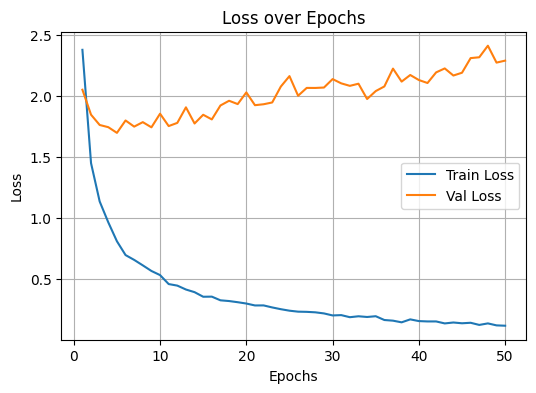

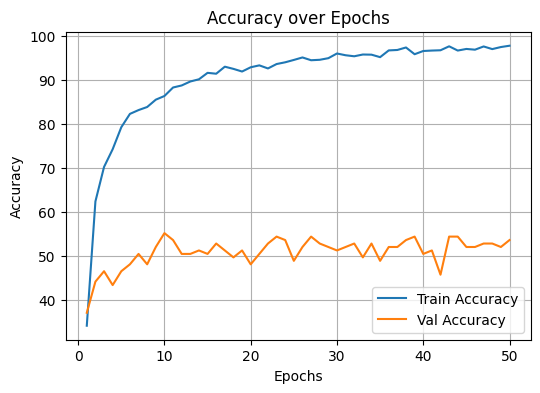

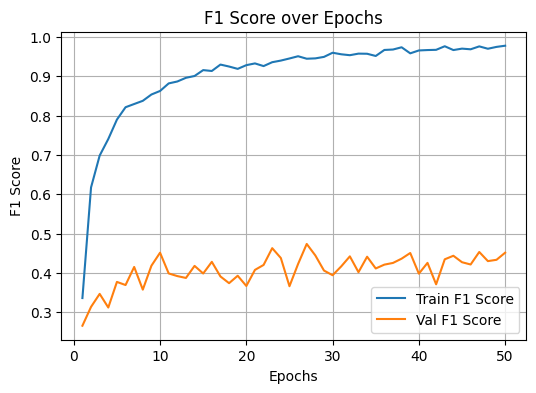

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="resnet50", use_hidden_layer=False, num_epochs=50)

#ResNet50 1 hidden layer

[1/50] Train Loss: 2.3157 | Val Loss: 2.1218 | Train Acc: 32.83% | Val Acc: 30.71% | Train F1: 0.3259 | Val F1: 0.2259
[2/50] Train Loss: 1.3475 | Val Loss: 1.8548 | Train Acc: 60.70% | Val Acc: 48.03% | Train F1: 0.6009 | Val F1: 0.3750
[3/50] Train Loss: 1.0139 | Val Loss: 1.8322 | Train Acc: 70.50% | Val Acc: 50.39% | Train F1: 0.7023 | Val F1: 0.4005
[4/50] Train Loss: 0.7805 | Val Loss: 1.7450 | Train Acc: 76.33% | Val Acc: 56.69% | Train F1: 0.7609 | Val F1: 0.4569
[5/50] Train Loss: 0.6706 | Val Loss: 1.8827 | Train Acc: 79.73% | Val Acc: 55.12% | Train F1: 0.7960 | Val F1: 0.4464
[6/50] Train Loss: 0.5672 | Val Loss: 1.8947 | Train Acc: 81.83% | Val Acc: 54.33% | Train F1: 0.8166 | Val F1: 0.4262
[7/50] Train Loss: 0.4963 | Val Loss: 1.9514 | Train Acc: 85.13% | Val Acc: 51.18% | Train F1: 0.8507 | Val F1: 0.3996
[8/50] Train Loss: 0.4085 | Val Loss: 1.9102 | Train Acc: 87.30% | Val Acc: 49.61% | Train F1: 0.8721 | Val F1: 0.3863
[9/50] Train Loss: 0.4308 | Val Loss: 2.1133 | T

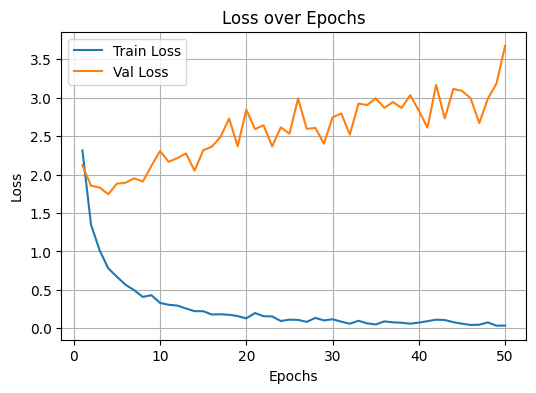

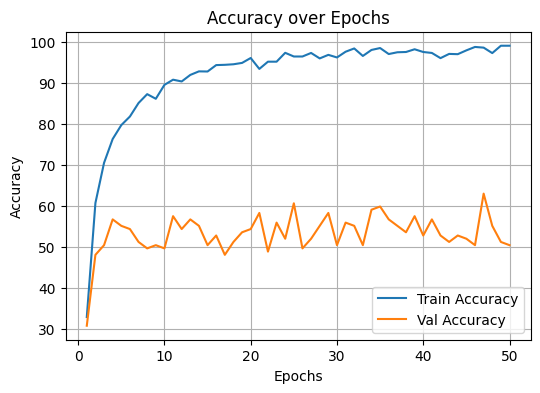

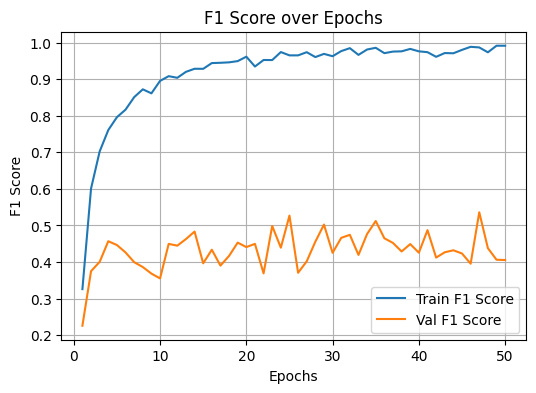

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="resnet50", use_hidden_layer=True, num_epochs=50)

#ResNet101 0 hidden layer

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 165MB/s]


[1/50] Train Loss: 2.3335 | Val Loss: 2.0654 | Train Acc: 34.90% | Val Acc: 45.67% | Train F1: 0.3451 | Val F1: 0.3537
[2/50] Train Loss: 1.3994 | Val Loss: 1.8401 | Train Acc: 63.10% | Val Acc: 50.39% | Train F1: 0.6268 | Val F1: 0.3918
[3/50] Train Loss: 1.0823 | Val Loss: 1.9380 | Train Acc: 71.17% | Val Acc: 48.03% | Train F1: 0.7102 | Val F1: 0.3955
[4/50] Train Loss: 0.9044 | Val Loss: 1.7654 | Train Acc: 75.87% | Val Acc: 52.76% | Train F1: 0.7571 | Val F1: 0.4508
[5/50] Train Loss: 0.7735 | Val Loss: 1.7149 | Train Acc: 79.30% | Val Acc: 50.39% | Train F1: 0.7917 | Val F1: 0.4167
[6/50] Train Loss: 0.6735 | Val Loss: 1.9939 | Train Acc: 82.53% | Val Acc: 50.39% | Train F1: 0.8243 | Val F1: 0.4198
[7/50] Train Loss: 0.6334 | Val Loss: 1.8257 | Train Acc: 83.27% | Val Acc: 54.33% | Train F1: 0.8314 | Val F1: 0.4588
[8/50] Train Loss: 0.5772 | Val Loss: 1.8414 | Train Acc: 85.00% | Val Acc: 51.97% | Train F1: 0.8491 | Val F1: 0.4347
[9/50] Train Loss: 0.5175 | Val Loss: 1.9328 | T

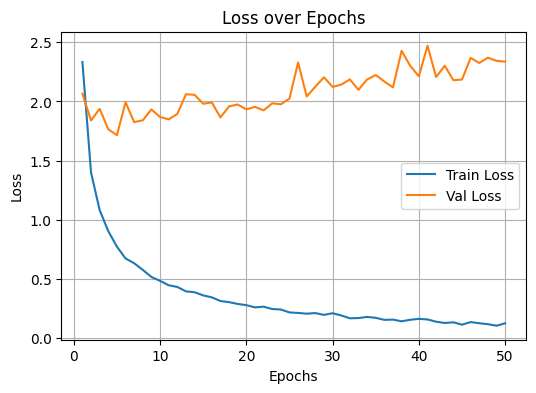

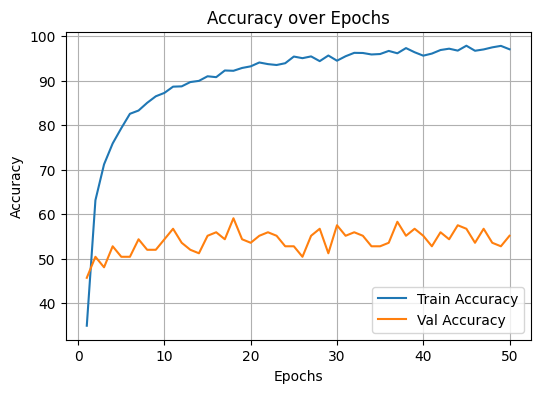

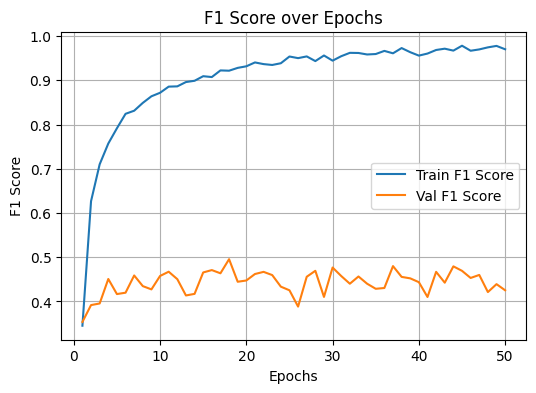

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="resnet101", use_hidden_layer=False, num_epochs=50)

#ResNet101 1 hidden layer

[1/50] Train Loss: 2.2223 | Val Loss: 1.9069 | Train Acc: 33.87% | Val Acc: 42.52% | Train F1: 0.3362 | Val F1: 0.3155
[2/50] Train Loss: 1.2890 | Val Loss: 1.9337 | Train Acc: 62.00% | Val Acc: 51.97% | Train F1: 0.6157 | Val F1: 0.4480
[3/50] Train Loss: 0.9301 | Val Loss: 2.0933 | Train Acc: 71.50% | Val Acc: 44.88% | Train F1: 0.7134 | Val F1: 0.3389
[4/50] Train Loss: 0.7506 | Val Loss: 2.0427 | Train Acc: 76.13% | Val Acc: 48.82% | Train F1: 0.7593 | Val F1: 0.3799
[5/50] Train Loss: 0.6614 | Val Loss: 1.9456 | Train Acc: 78.87% | Val Acc: 47.24% | Train F1: 0.7884 | Val F1: 0.3836
[6/50] Train Loss: 0.5372 | Val Loss: 2.1877 | Train Acc: 84.00% | Val Acc: 48.82% | Train F1: 0.8390 | Val F1: 0.3804
[7/50] Train Loss: 0.4523 | Val Loss: 2.0829 | Train Acc: 85.30% | Val Acc: 48.03% | Train F1: 0.8525 | Val F1: 0.4088
[8/50] Train Loss: 0.4340 | Val Loss: 2.2213 | Train Acc: 85.90% | Val Acc: 50.39% | Train F1: 0.8586 | Val F1: 0.4203
[9/50] Train Loss: 0.4009 | Val Loss: 2.0449 | T

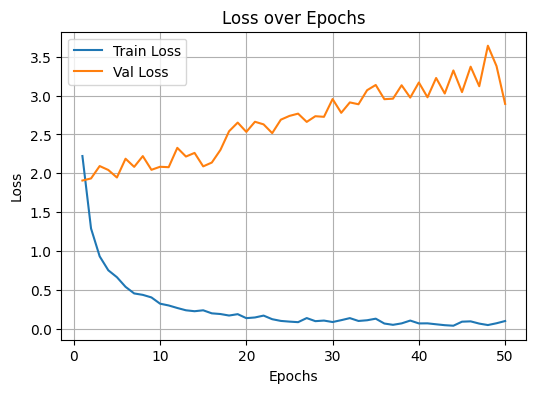

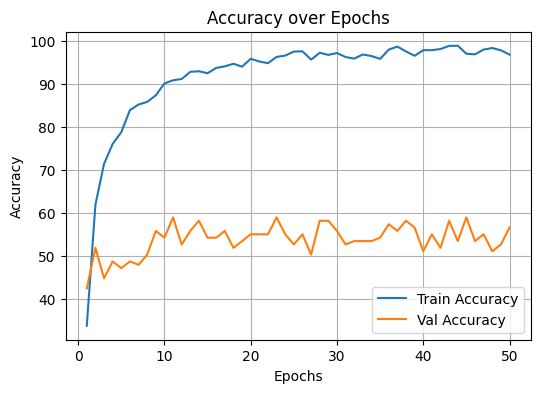

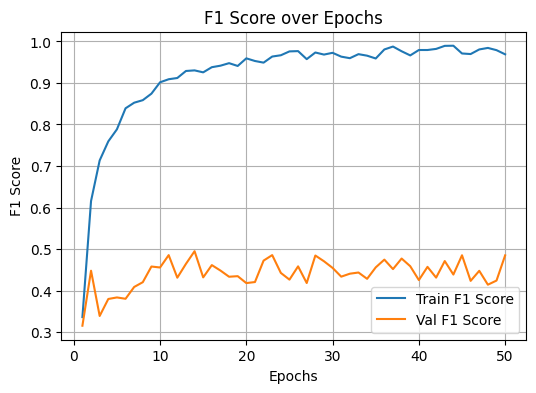

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_training(model_name="resnet101", use_hidden_layer=True, num_epochs=50)

#FLOPS DAN LATENCY

In [ ]:
!pip install timm fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
from fvcore.nn import FlopCountAnalysis
import time
import pandas as pd

def calculate_flops_and_latency(model, input_size=(1, 3, 224, 224)):
    model.eval()
    dummy_input = torch.randn(*input_size)

    try:
        flops = FlopCountAnalysis(model, dummy_input)
        total_flops = flops.total()
    except Exception as e:
        print(f"FLOPs error: {e}")
        total_flops = None

    try:
        with torch.no_grad():
            start_time = time.time()
            _ = model(dummy_input)
            end_time = time.time()
        latency = end_time - start_time
    except Exception as e:
        print(f"Latency error: {e}")
        latency = None

    return total_flops, latency

model_names = [
    "convnext_tiny", "convnext_small", "convnext_base", "convnext_large",
    "efficientnet_v2_s", "efficientnet_v2_m", "efficientnet_v2_l",
    "mobilenet_v3_small", "mobilenet_v3_large",
    "resnest50", "resnest101", "resnest200", "resnest269",
    "resnet34", "resnet50", "resnet101"
]


results = []

default_input_size = (1, 3, 224, 224)
fallback_input_size = (1, 3, 256, 256)

for model_name in model_names:
    for use_hidden_layer in [False, True]:
        model = create_model(model_name, num_classes=20, use_hidden_layer=use_hidden_layer)

        try:
            flops, latency = calculate_flops_and_latency(model, input_size=default_input_size)
            input_size_used = default_input_size
            if flops is None or latency is None:
                raise ValueError("Invalid result, trying fallback")
        except:
            flops, latency = calculate_flops_and_latency(model, input_size=fallback_input_size)
            input_size_used = fallback_input_size

        results.append({
            "Model": model_name,
            "Hidden Layer": "Yes" if use_hidden_layer else "No",
            "Input Size": f"{input_size_used[2]}x{input_size_used[3]}",
            "FLOPs": flops,
            "FLOPs (GFLOPs)": round(flops / 1e9, 3) if flops is not None else None,
            "Latency (seconds)": latency
        })

df_results = pd.DataFrame(results)
df_results.to_csv("/content/drive/MyDrive/Tugas Akhir Code/FLOPS DAN LATENCY/Hasil_FLOPs_Latency.csv", index=False)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 127MB/s]
features.1.0.stochastic_depth, features.1.1.stochastic_depth, features.1.2.stochastic_depth, features.3.0.stochastic_depth, features.3.1.stochastic_depth, features.3.2.stochastic_depth, features.5.0.stochastic_depth, features.5.1.stochastic_depth, features.5.2.stochastic_depth, features.5.3.stochastic_depth, features.5.4.stochastic_depth, features.5.5.stochastic_depth, features.5.6.stochastic_depth, features.5.7.stochastic_depth, features.5.8.stochastic_depth, features.7.0.stochastic_depth, features.7.1.stochastic_depth, features.7.2.stochastic_depth
features.1.0.stochastic_depth, features.1.1.stochastic_depth, features.1.2.stochastic_depth, features.3.0.stochastic_depth, features.3.1.stochastic_depth, features.3.2.stochastic_depth, features.5.0.stochastic_depth, features.5.1.stochastic_depth, fe

KeyboardInterrupt: 

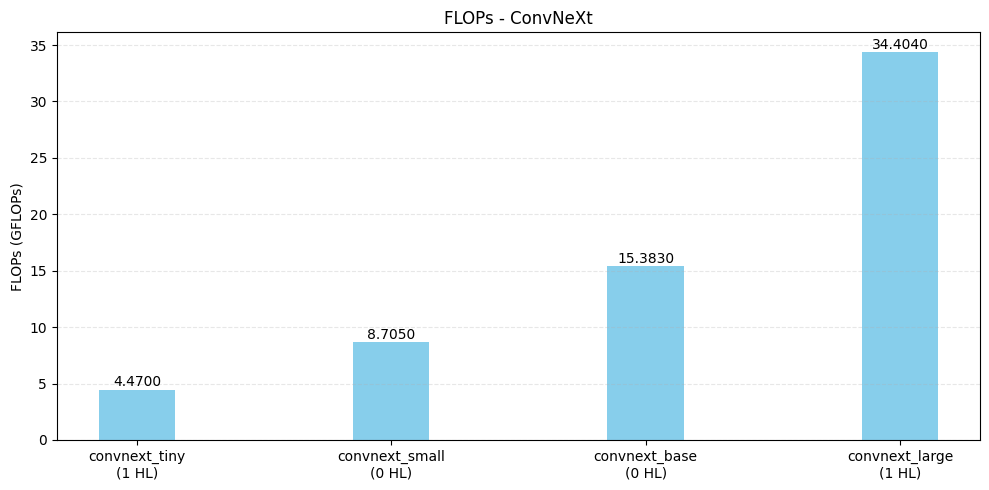

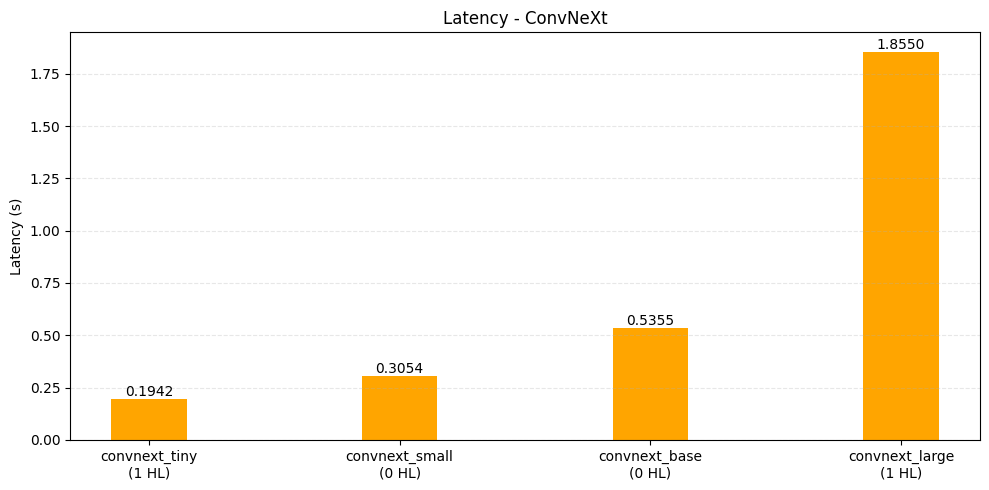

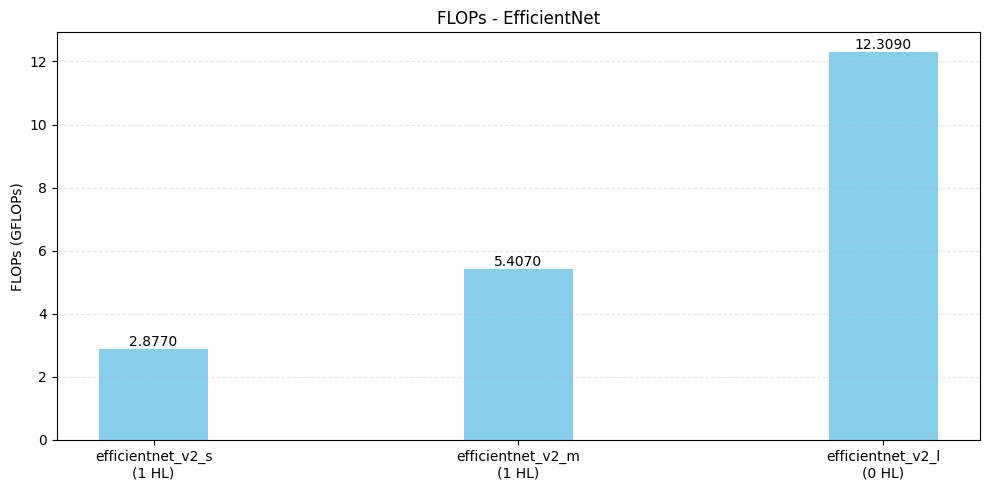

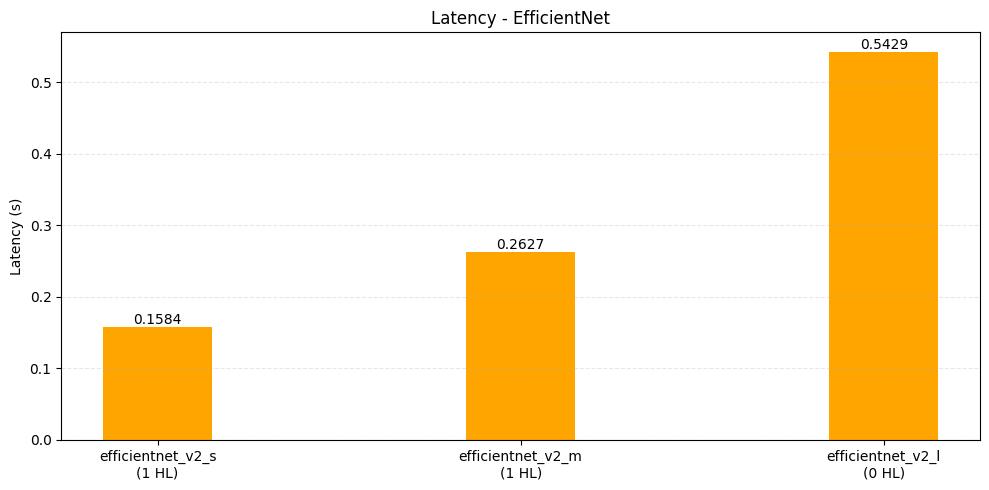

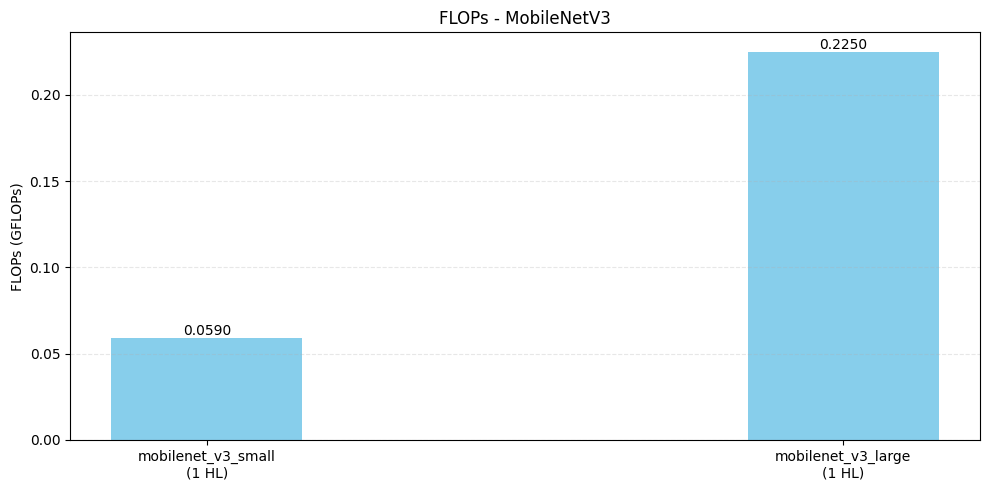

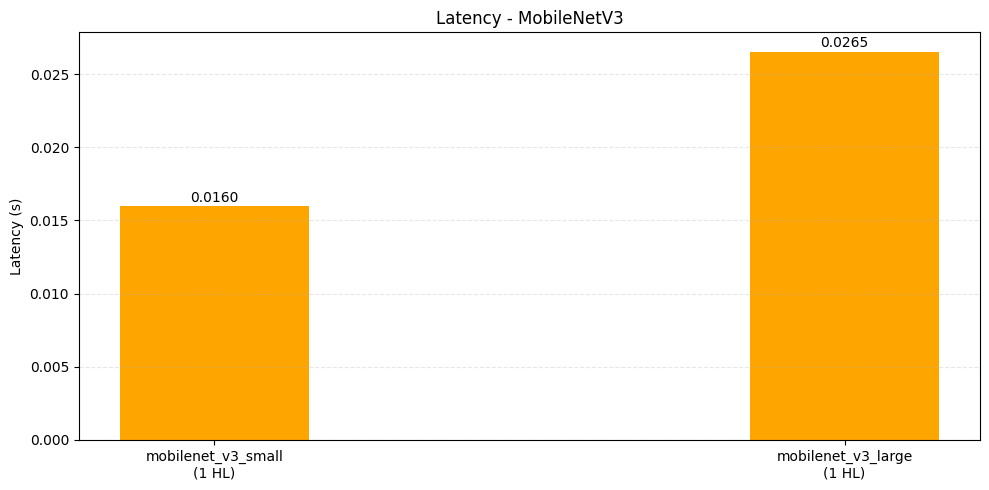

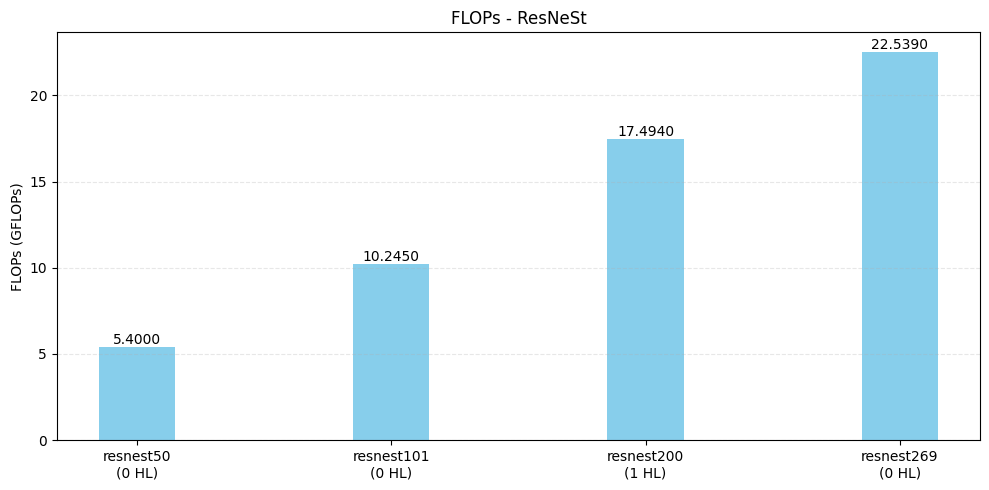

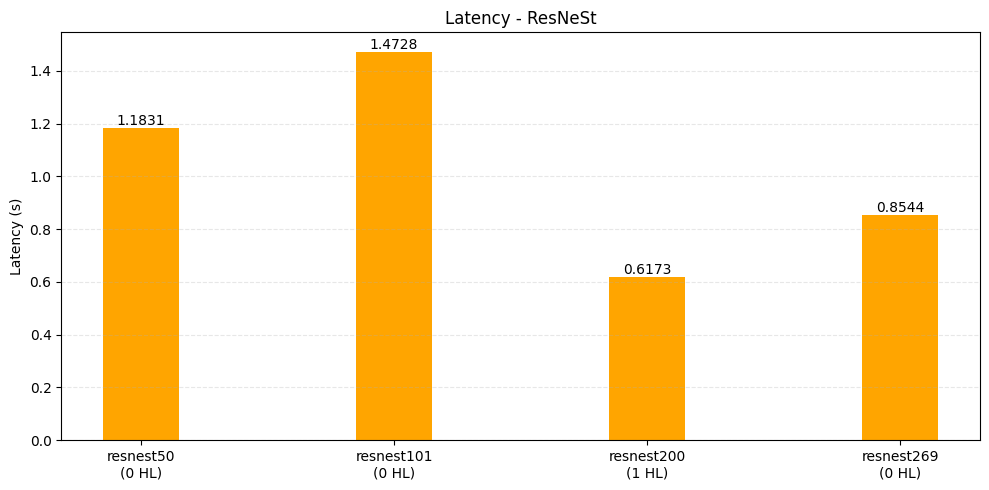

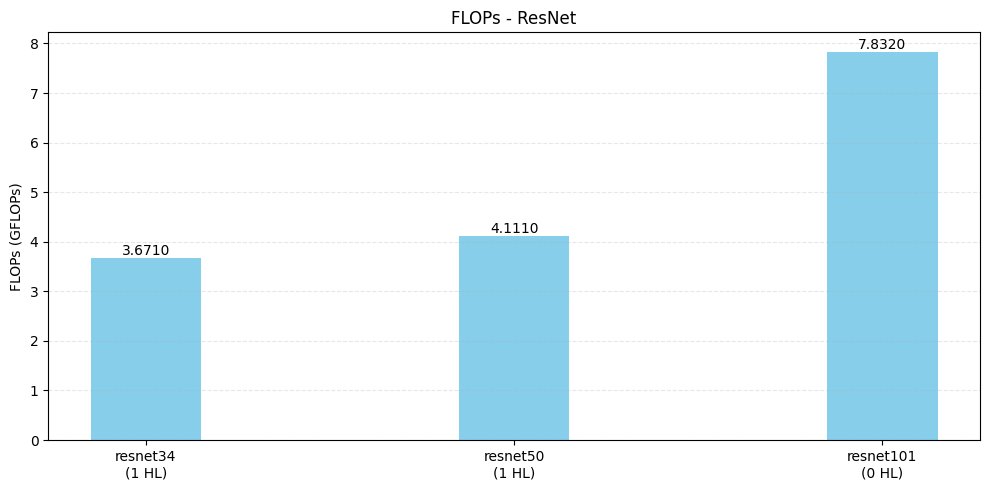

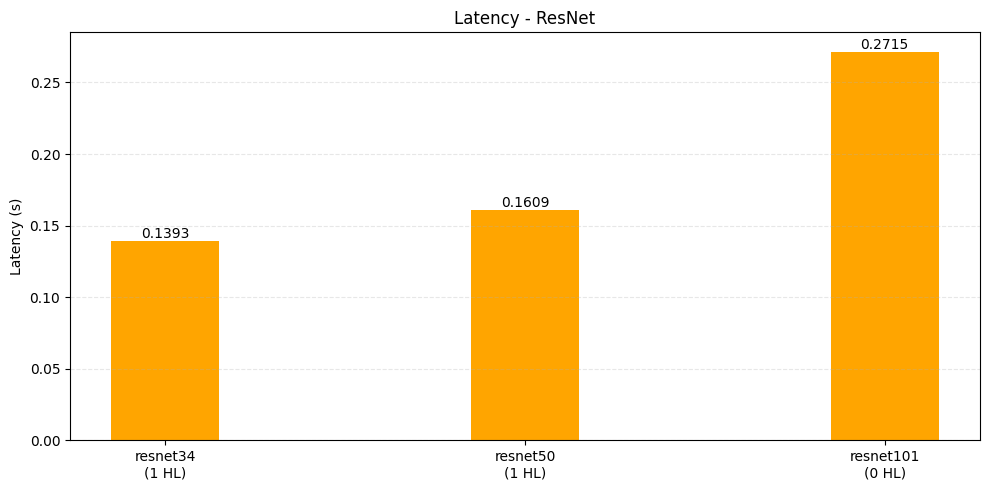

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/Tugas Akhir Code/FLOPS DAN LATENCY/Hasil_FLOPs_Latency.csv')

model_groups = {
    'ConvNeXt': {'convnext_tiny': 'Yes', 'convnext_small': 'No', 'convnext_base': 'No', 'convnext_large': 'Yes'},
    'EfficientNet': {'efficientnet_v2_s': 'Yes', 'efficientnet_v2_m': 'Yes', 'efficientnet_v2_l': 'No'},
    'MobileNetV3': {'mobilenet_v3_small': 'Yes', 'mobilenet_v3_large': 'Yes'},
    'ResNeSt': {'resnest50': 'No', 'resnest101': 'No', 'resnest200': 'Yes', 'resnest269': 'No'},
    'ResNet': {'resnet34': 'Yes', 'resnet50': 'Yes', 'resnet101': 'No'}
}

for group_name, models_config in model_groups.items():
    models = list(models_config.keys())
    x = np.arange(len(models))
    flops, latency, labels = [], [], []

    for m in models:
        hl = models_config[m]
        row = df[(df['Model'] == m) & (df['Hidden Layer'] == hl)]
        flops.append(row['FLOPs (GFLOPs)'].values[0] if not row.empty else 0)
        latency.append(row['Latency (seconds)'].values[0] if not row.empty else 0)
        labels.append(f"{m}\n({'1 HL' if hl == 'Yes' else '0 HL'})")

    fig1, ax1 = plt.subplots(figsize=(10, 5))
    fb = ax1.bar(x, flops, color='skyblue', width=0.3)
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=0)
    ax1.set_ylabel('FLOPs (GFLOPs)')
    ax1.set_title(f'FLOPs - {group_name}')
    ax1.grid(axis='y', linestyle='--', alpha=0.3)

    for b in fb:
        h = b.get_height()
        ax1.text(b.get_x() + b.get_width()/2, h + 0.0001, f'{h:.4f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    fig2, ax2 = plt.subplots(figsize=(10, 5))
    lb = ax2.bar(x, latency, color='orange', width=0.3)
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, rotation=0)
    ax2.set_ylabel('Latency (s)')
    ax2.set_title(f'Latency - {group_name}')
    ax2.grid(axis='y', linestyle='--', alpha=0.3)

    for b in lb:
        h = b.get_height()
        ax2.text(b.get_x() + b.get_width()/2, h + 0.0001, f'{h:.4f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()


#BEST OTOMATIS

In [ ]:
import os
import pandas as pd

folder_path = '/content/drive/MyDrive/Tugas Akhir Code/Hasil Training'

In [ ]:
summary = []

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        try:
            df = pd.read_csv(file_path)

            if 'Val Accuracy' in df.columns and 'Epoch' in df.columns:
                max_acc = df['Val Accuracy'].max()
                best_epoch = df[df['Val Accuracy'] == max_acc]['Epoch'].values[0]
                summary.append({
                    'Model File': filename,
                    'Best Epoch': int(best_epoch),
                    'Best Val Accuracy': round(max_acc, 2)
                })
        except Exception as e:
            print(f"Gagal membaca file {filename}: {e}")

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values(by='Best Val Accuracy', ascending=False).reset_index(drop=True)
summary_df.head()

Model File  Best Epoch  Best Val Accuracy
0   hasil_convnext_tiny_1hidden.csv          46              70.08
1  hasil_convnext_small_0hidden.csv          14              70.08
2  hasil_convnext_large_1hidden.csv          18              70.08
3   hasil_convnext_tiny_0hidden.csv           7              69.29
4  hasil_convnext_large_0hidden.csv          29              69.29

In [ ]:
save_folder = '/content/drive/MyDrive/Tugas Akhir Code/BEST OTOMATIS'
save_path = os.path.join(save_folder, 'best_otomatis.csv')
summary_df.to_csv(save_path, index=False)
print(f"BEST OTOMATIS BERHASIL DISIMPAN {save_path}")

BEST OTOMATIS BERHASIL DISIMPAN /content/drive/MyDrive/Tugas Akhir Code/BEST OTOMATIS/best_otomatis.csv


#GRAFIK AKHIR

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
model_names = ['convnext_tiny', 'convnext_small', 'convnext_base', 'convnext_large','efficientnet_v2_s', 'efficientnet_v2_m', 'efficientnet_v2_l', 'mobilenet_v3_small', 'mobilenet_v3_large','resnest50', 'resnest101', 'resnest200', 'resnest269','resnet34', 'resnet50', 'resnet101']

for model in model_names:
    print(f"Plotting for: {model}")

    file_0 = f'/content/drive/MyDrive/Tugas Akhir Code/Hasil Training/hasil_{model}_0hidden.csv'
    file_1 = f'/content/drive/MyDrive/Tugas Akhir Code/Hasil Training/hasil_{model}_1hidden.csv'

    df_0 = pd.read_csv(file_0)
    df_1 = pd.read_csv(file_1)

    best_acc_0 = df_0['Val Accuracy'].idxmax()
    best_acc_1 = df_1['Val Accuracy'].idxmax()
    best_f1_0 = df_0['Val F1 Score'].idxmax()
    best_f1_1 = df_1['Val F1 Score'].idxmax()

    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Model: {model.replace('_', ' ').title()}", fontsize=16)

    plt.subplot(1, 2, 1)
    plt.plot(df_0['Epoch'], df_0['Val Accuracy'], label='0 Hidden')
    plt.plot(df_1['Epoch'], df_1['Val Accuracy'], label='1 Hidden')
    plt.scatter(df_0['Epoch'][best_acc_0], df_0['Val Accuracy'][best_acc_0], color='red', zorder=5)
    plt.scatter(df_1['Epoch'][best_acc_1], df_1['Val Accuracy'][best_acc_1], color='red', zorder=5)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    textstr = (
        f"Max Acc 0H: {df_0['Val Accuracy'][best_acc_0]:.2f}% (Ep {df_0['Epoch'][best_acc_0]})\n"
        f"Max Acc 1H: {df_1['Val Accuracy'][best_acc_1]:.2f}% (Ep {df_1['Epoch'][best_acc_1]})"
    )
    plt.gca().text(0.5, -0.35, textstr, transform=plt.gca().transAxes,
                   fontsize=10, verticalalignment='top',
                   bbox=dict(facecolor='lightgrey', alpha=0.5), ha='center')

    plt.subplot(1, 2, 2)
    plt.plot(df_0['Epoch'], df_0['Val F1 Score'], label='0 Hidden')
    plt.plot(df_1['Epoch'], df_1['Val F1 Score'], label='1 Hidden')
    plt.scatter(df_0['Epoch'][best_f1_0], df_0['Val F1 Score'][best_f1_0], color='red', zorder=5)
    plt.scatter(df_1['Epoch'][best_f1_1], df_1['Val F1 Score'][best_f1_1], color='red', zorder=5)
    plt.xlabel('Epoch')
    plt.ylabel('Validation F1 Score')
    plt.title('Validation F1 Score')
    plt.legend()

    textstr2 = (
        f"Max F1 0H: {df_0['Val F1 Score'][best_f1_0]:.2f} (Ep {df_0['Epoch'][best_f1_0]})\n"
        f"Max F1 1H: {df_1['Val F1 Score'][best_f1_1]:.2f} (Ep {df_1['Epoch'][best_f1_1]})"
    )
    plt.gca().text(0.5, -0.35, textstr2, transform=plt.gca().transAxes,
                   fontsize=10, verticalalignment='top',
                   bbox=dict(facecolor='lightgrey', alpha=0.5), ha='center')

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

#PENENTUAN MODEL TERBAIK

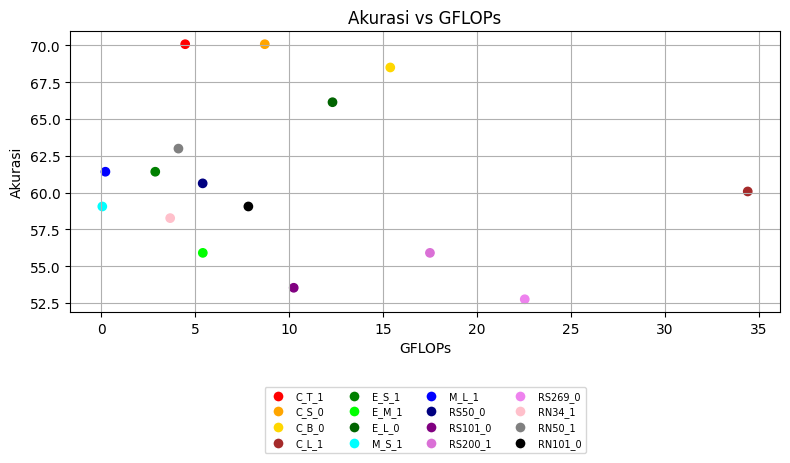

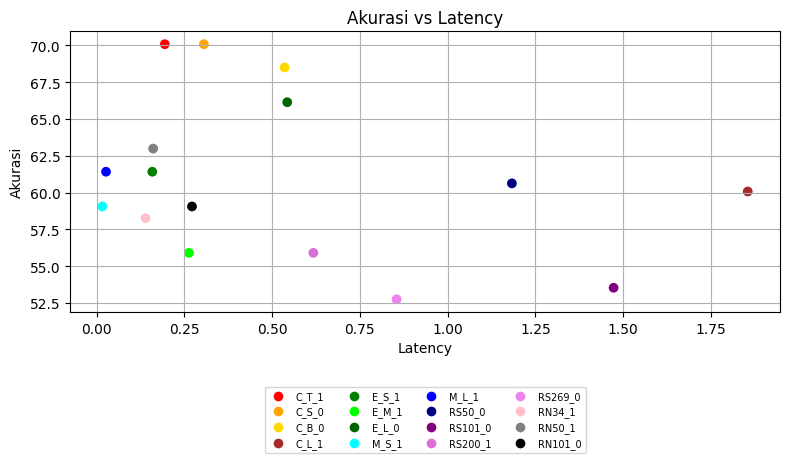

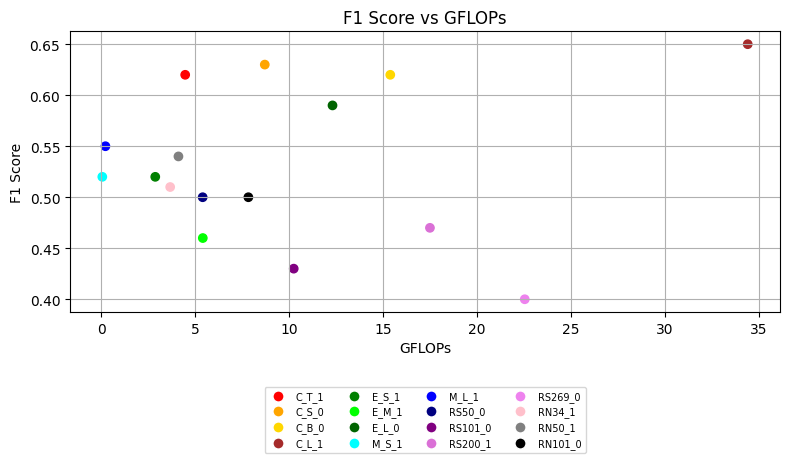

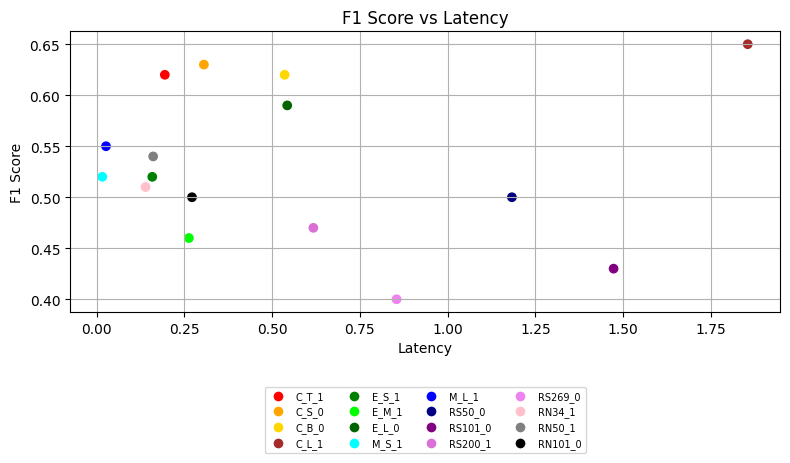

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

url = "https://docs.google.com/spreadsheets/d/1xpViJG_63jn0zGkCM_mRxu6nNLZm0FF6M8QhQlbl-C0/export?format=csv"
df = pd.read_csv(url)

for col in ['Akurasi', 'F1 score', 'GFLOPs', 'Latency']:
    df[col] = df[col].astype(str).str.replace(',', '.', regex=False).astype(float)

model2_colors = {
    'C_T_1': 'red', 'C_S_0': 'orange', 'C_B_0': 'gold', 'C_L_1': 'brown',
    'E_S_1': 'green', 'E_M_1': 'lime', 'E_L_0': 'darkgreen',
    'M_S_1': 'cyan', 'M_L_1': 'blue',
    'RS50_0': 'navy', 'RS101_0': 'purple', 'RS200_1': 'orchid', 'RS269_0': 'violet',
    'RN34_1': 'pink', 'RN50_1': 'gray', 'RN101_0': 'black',
}
colors = [model2_colors.get(m, 'black') for m in df['Model2']]

def get_legend():
    return [
        Line2D([0], [0], marker='o', color='w', label=model2,
               markerfacecolor=color, markersize=8)
        for model2, color in model2_colors.items()
    ]

# Grafik Akurasi vs GFLOPs
plt.figure(figsize=(8, 5))
plt.scatter(df['GFLOPs'], df['Akurasi'], color=colors)
plt.title('Akurasi vs GFLOPs')
plt.xlabel('GFLOPs')
plt.ylabel('Akurasi')
plt.grid(True)
plt.legend(handles=get_legend(), fontsize=7, ncol=4, loc='upper center', bbox_to_anchor=(0.5, -0.25))
plt.tight_layout()
plt.show()

# Grafik Akurasi vs Latency
plt.figure(figsize=(8, 5))
plt.scatter(df['Latency'], df['Akurasi'], color=colors)
plt.title('Akurasi vs Latency')
plt.xlabel('Latency')
plt.ylabel('Akurasi')
plt.grid(True)
plt.legend(handles=get_legend(), fontsize=7, ncol=4, loc='upper center', bbox_to_anchor=(0.5, -0.25))
plt.tight_layout()
plt.show()

# Grafik F1 Score vs GFLOPs
plt.figure(figsize=(8, 5))
plt.scatter(df['GFLOPs'], df['F1 score'], color=colors)
plt.title('F1 Score vs GFLOPs')
plt.xlabel('GFLOPs')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend(handles=get_legend(), fontsize=7, ncol=4, loc='upper center', bbox_to_anchor=(0.5, -0.25))
plt.tight_layout()
plt.show()

# Grafik F1 Score vs Latency
plt.figure(figsize=(8, 5))
plt.scatter(df['Latency'], df['F1 score'], color=colors)
plt.title('F1 Score vs Latency')
plt.xlabel('Latency')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend(handles=get_legend(), fontsize=7, ncol=4, loc='upper center', bbox_to_anchor=(0.5, -0.25))
plt.tight_layout()
plt.show()